# DHCR24-ThioMac Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
sys.path.append("/home/jenhan/code/seq_merge_pipe/")
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from matplotlib_venn import venn3, venn2
import scipy
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
sns.set_context('talk')

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Preprocessing

In [21]:
# file directories
workingDirectory = '/home/jenhan/analysis/dhcr24_analysis/'
binDirectory = '/home/jenhan/bin/'
genomes = ['hg19','mm10', 'hg38']
peakDirectory = workingDirectory + 'peaks/'
scratchDirectory = workingDirectory + '/scratch/'
logFilePath = workingDirectory + '/log_files_thiomac/'
tagDirPath = workingDirectory + '/tag_directories_thiomac/'
inputDirectory = workingDirectory + '/input/'
idrDirectory = workingDirectory + '/idr_thiomac/'

# tagDirPath = workingDirectory + '/all_tag_directories/'
# logFilePath = workingDirectory + '/all_log_files/'

os.chdir(workingDirectory)

# map ugly file names to prettier looking file names
# if not os.path.isfile("nameMapping.tsv"):
nameMappingFile = open("nameMapping.tsv", "w")
for f in os.listdir(tagDirPath):
    rootName=f
#     for gen in genomes:
#         rootName = rootName.replace('.' + gen + '.star.log','').replace('.' +gen + '.bowtie2.log','')
    nameMappingFile.write(rootName + '\t' + rootName + '\n')
nameMappingFile.close()

# read in and parse name mapping file and create a DataFrame representation
with open("nameMapping.tsv") as f:
    data = f.readlines()
strains = []
treatments = []
owners = []
dates = []
originalNames = []
cleanedNames = []
for line in data:
    tokens = line.strip().split("\t")
    originalName = tokens[0]
    metaDataTokens = tokens[1].split('_')
    
    originalNames.append(originalName)
    cleanedNames.append(tokens[1])
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip().split('-')[0]
    treatment = metaDataTokens[2].strip()
    owner = metaDataTokens[3].strip()
    date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  cleanedNames]).transpose()
metadata_frame.columns = ['strain', 
                         'treatment', 
                         'owner', 
                         'originalName', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = [x for x in t.split('-')][-2]
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

# create dictionary for convenience
originalName_cleanedName_dict = dict(zip(metadata_frame["originalName"], metadata_frame["sampleName"])) # {originalName:newName}
cleanedName_originalName_dict = dict(zip(metadata_frame["sampleName"], metadata_frame["originalName"])) # {newName:originalName}

### read in log files ###

# create data frame summarizing mapping quality logs
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_originalNames =[]
# from tagInfo.txt
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []

for logFile in os.listdir(logFilePath):
    with open(logFilePath + '/' + logFile) as f:
        data = f.readlines()
    rootName = logFile
    for gen in genomes:
        rootName = rootName.replace('.' + gen + '.star.log','').replace('.' +gen + '.bowtie2.log','')
    totalReads = int(data[5].split()[5])
    uniquelyMappedReads = int(data[8].split()[5])
    multiMappedReads = int(data[23].split()[8])
    unmappedReads = totalReads - uniquelyMappedReads - multiMappedReads
#     pbc = float(data[-1].split()[-1])

    _originalNames.append(rootName)
    _totalReads.append(totalReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)

for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
        
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['originalName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']
mappingStats_frame = mappingStats_frame[mappingStats_frame['originalName'].isin(metadata_frame['originalName'])]

summary_frame = metadata_frame.merge(mappingStats_frame, on='originalName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['simpleTreatment'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics_thiomac.tsv', sep='\t', index=False)

## Mapping Quality Control

### Plot Distributions of Mapping Statistics

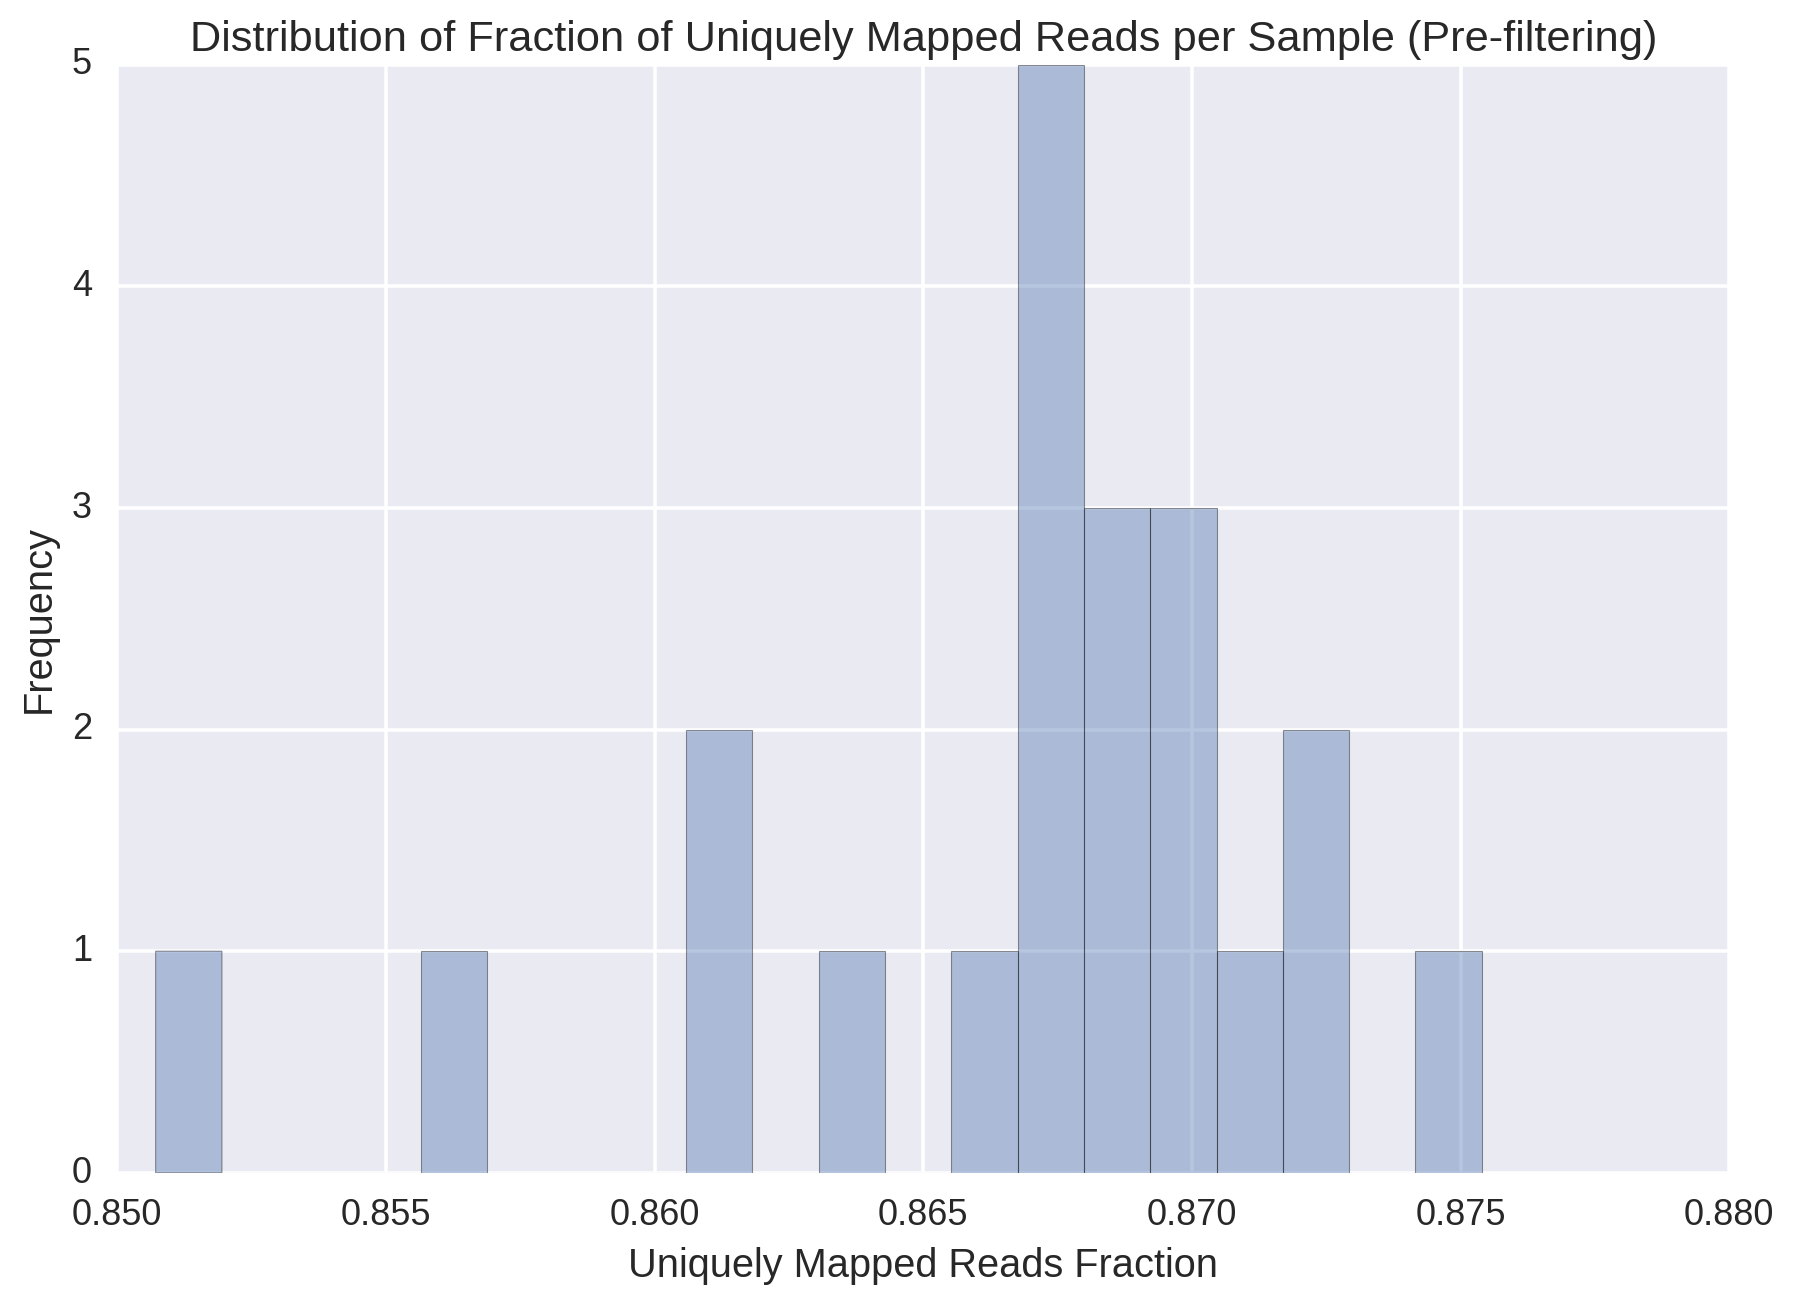

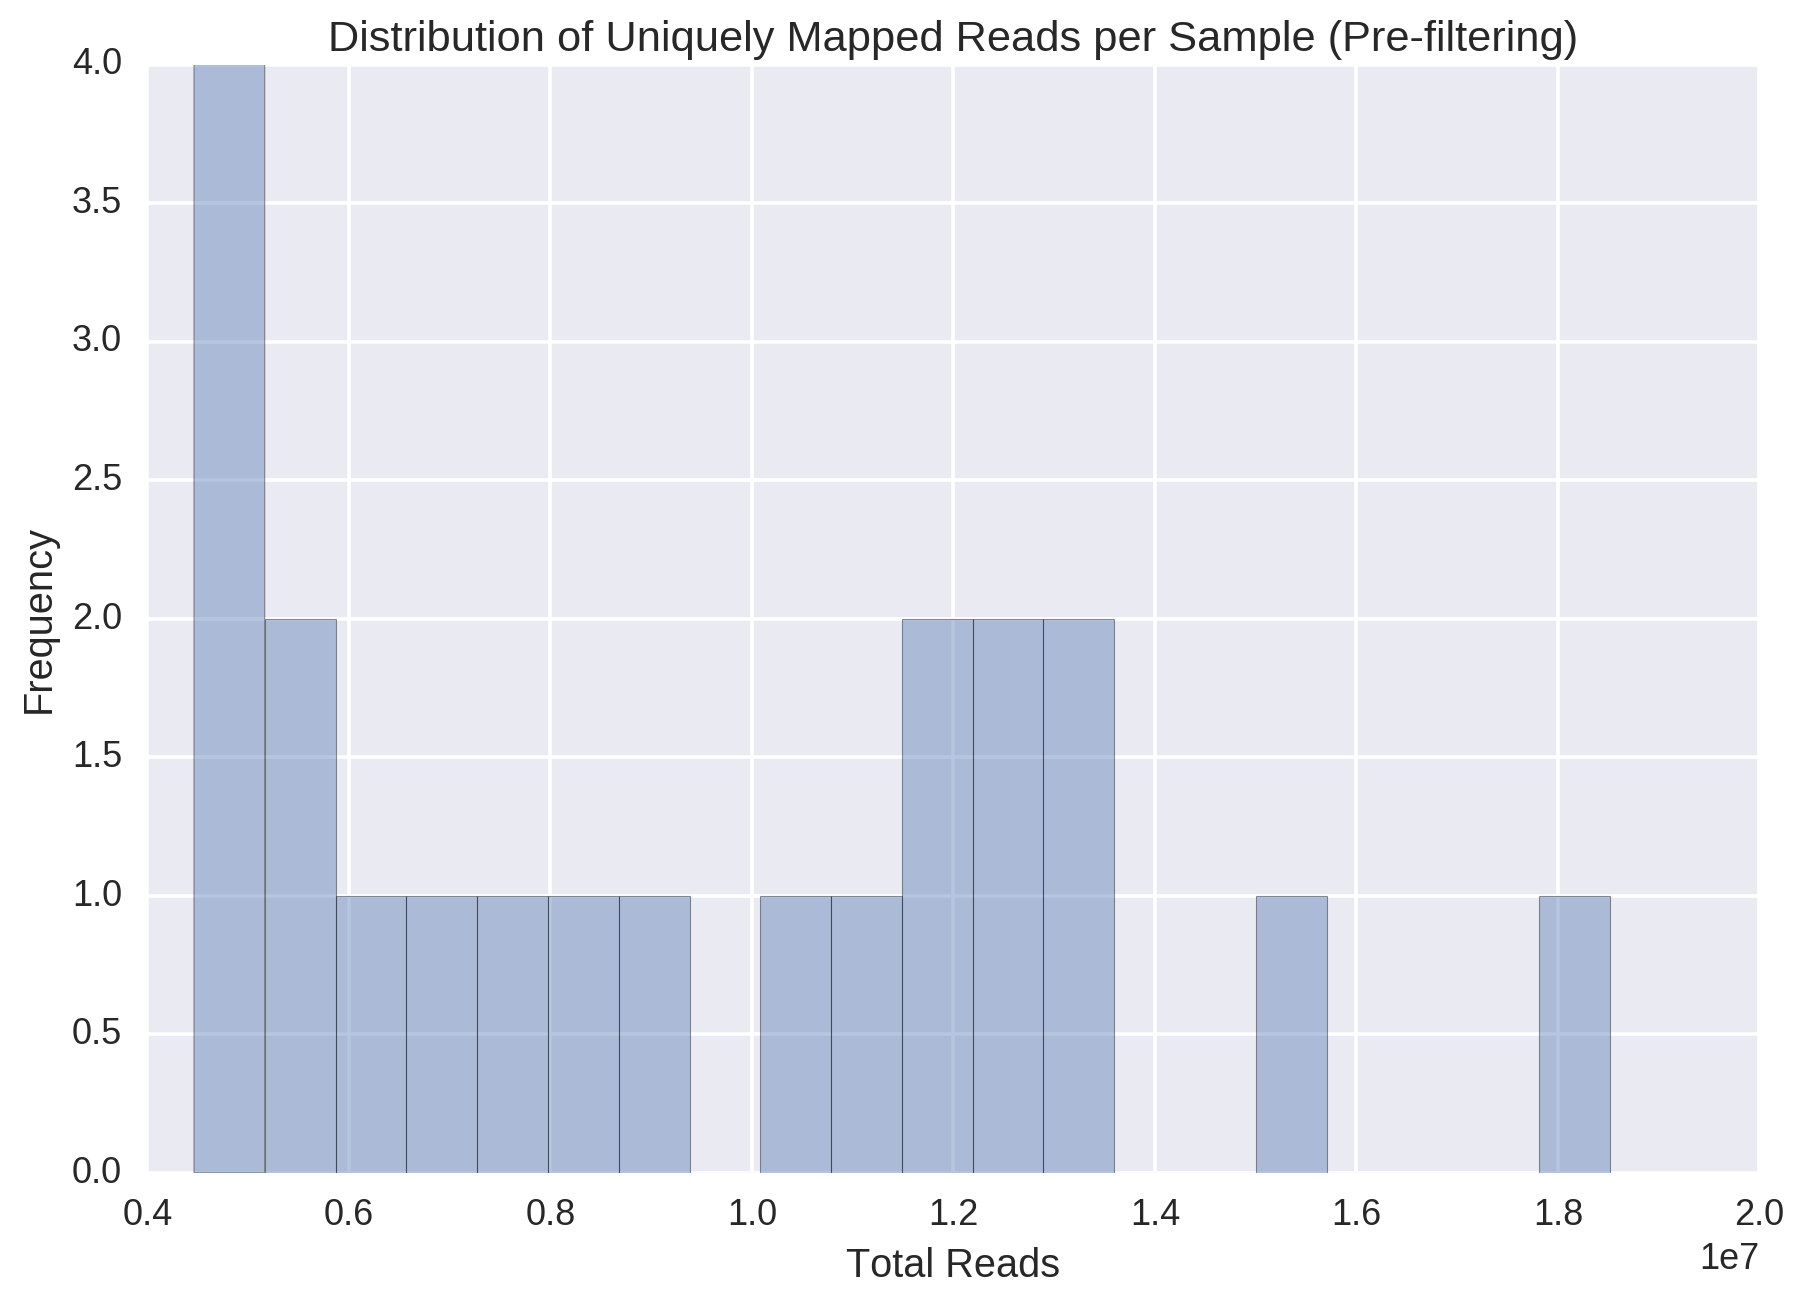

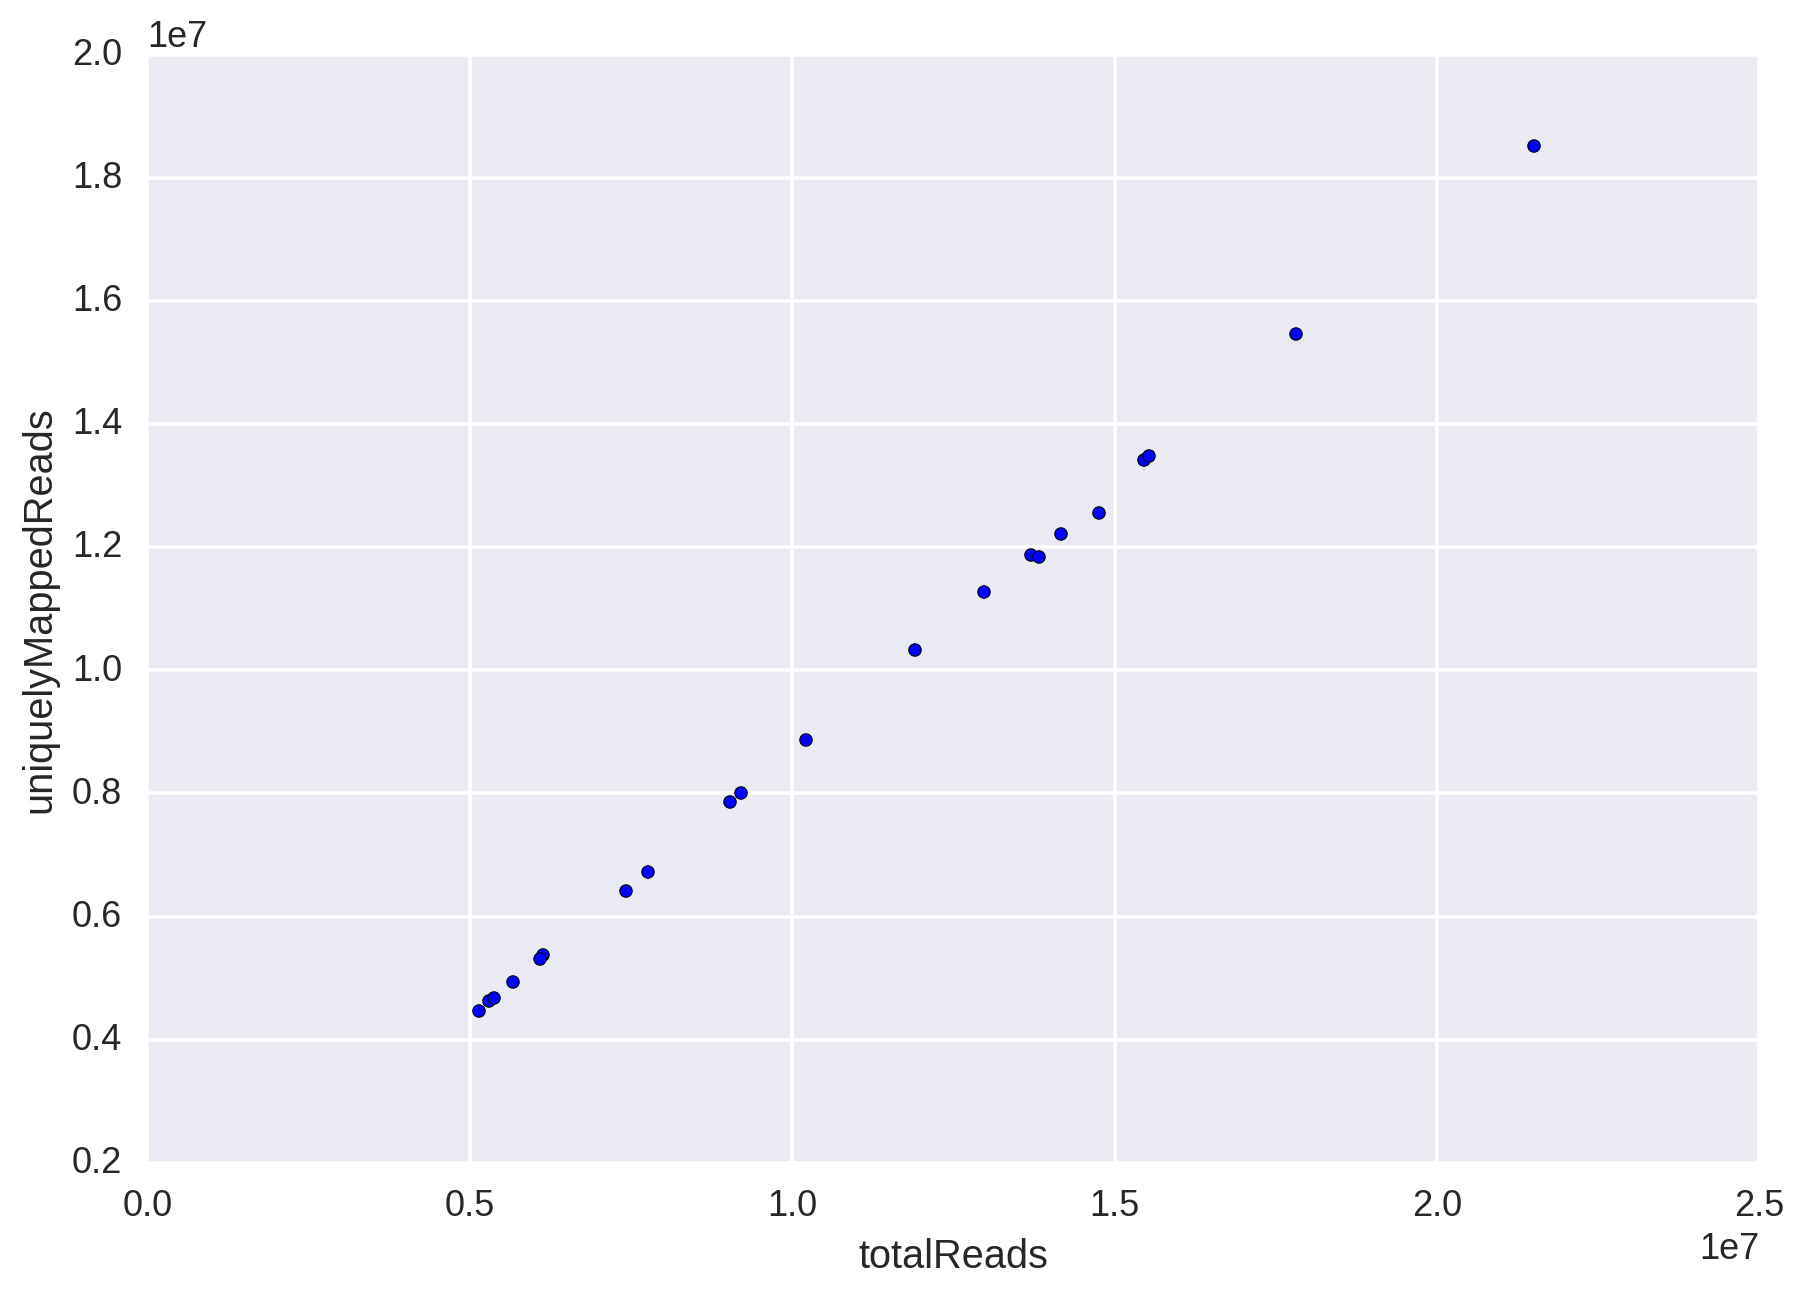

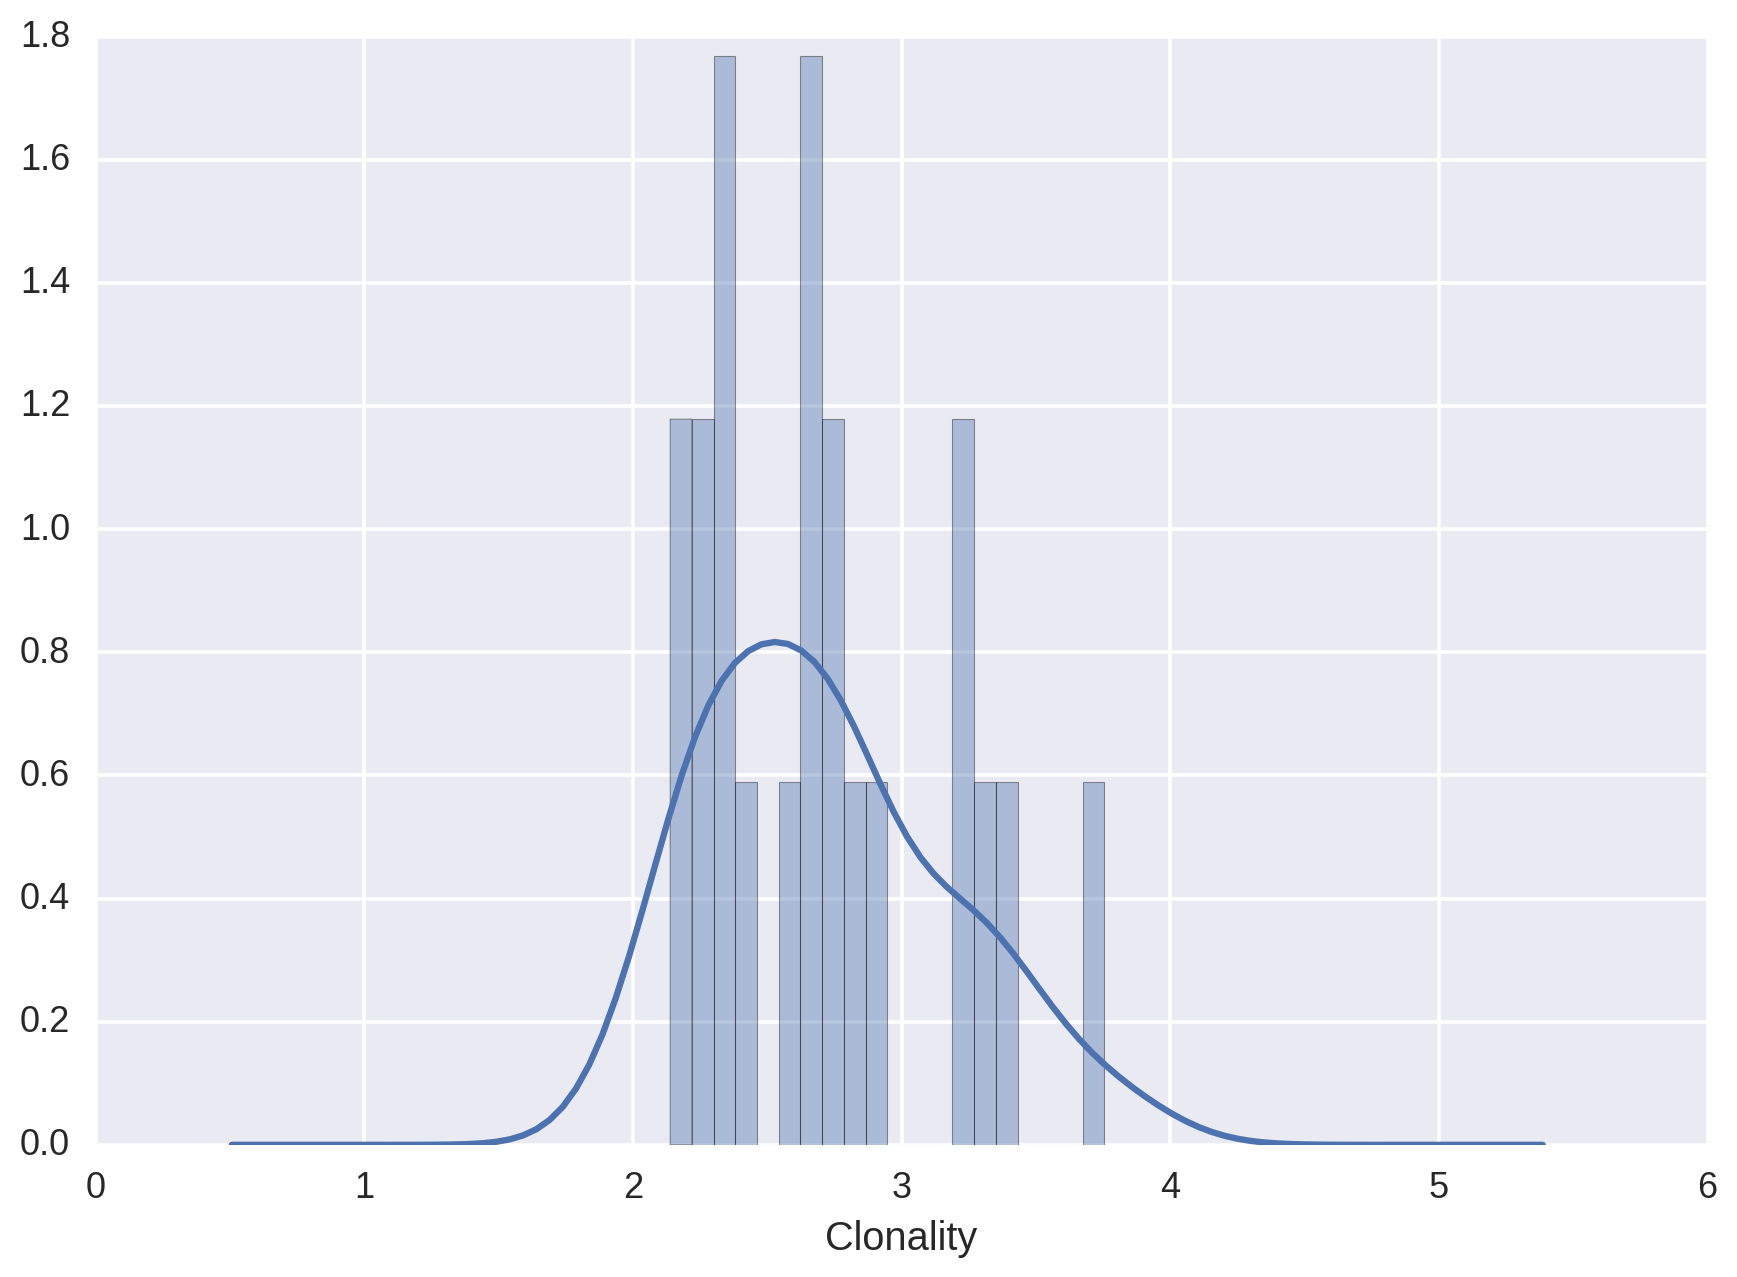

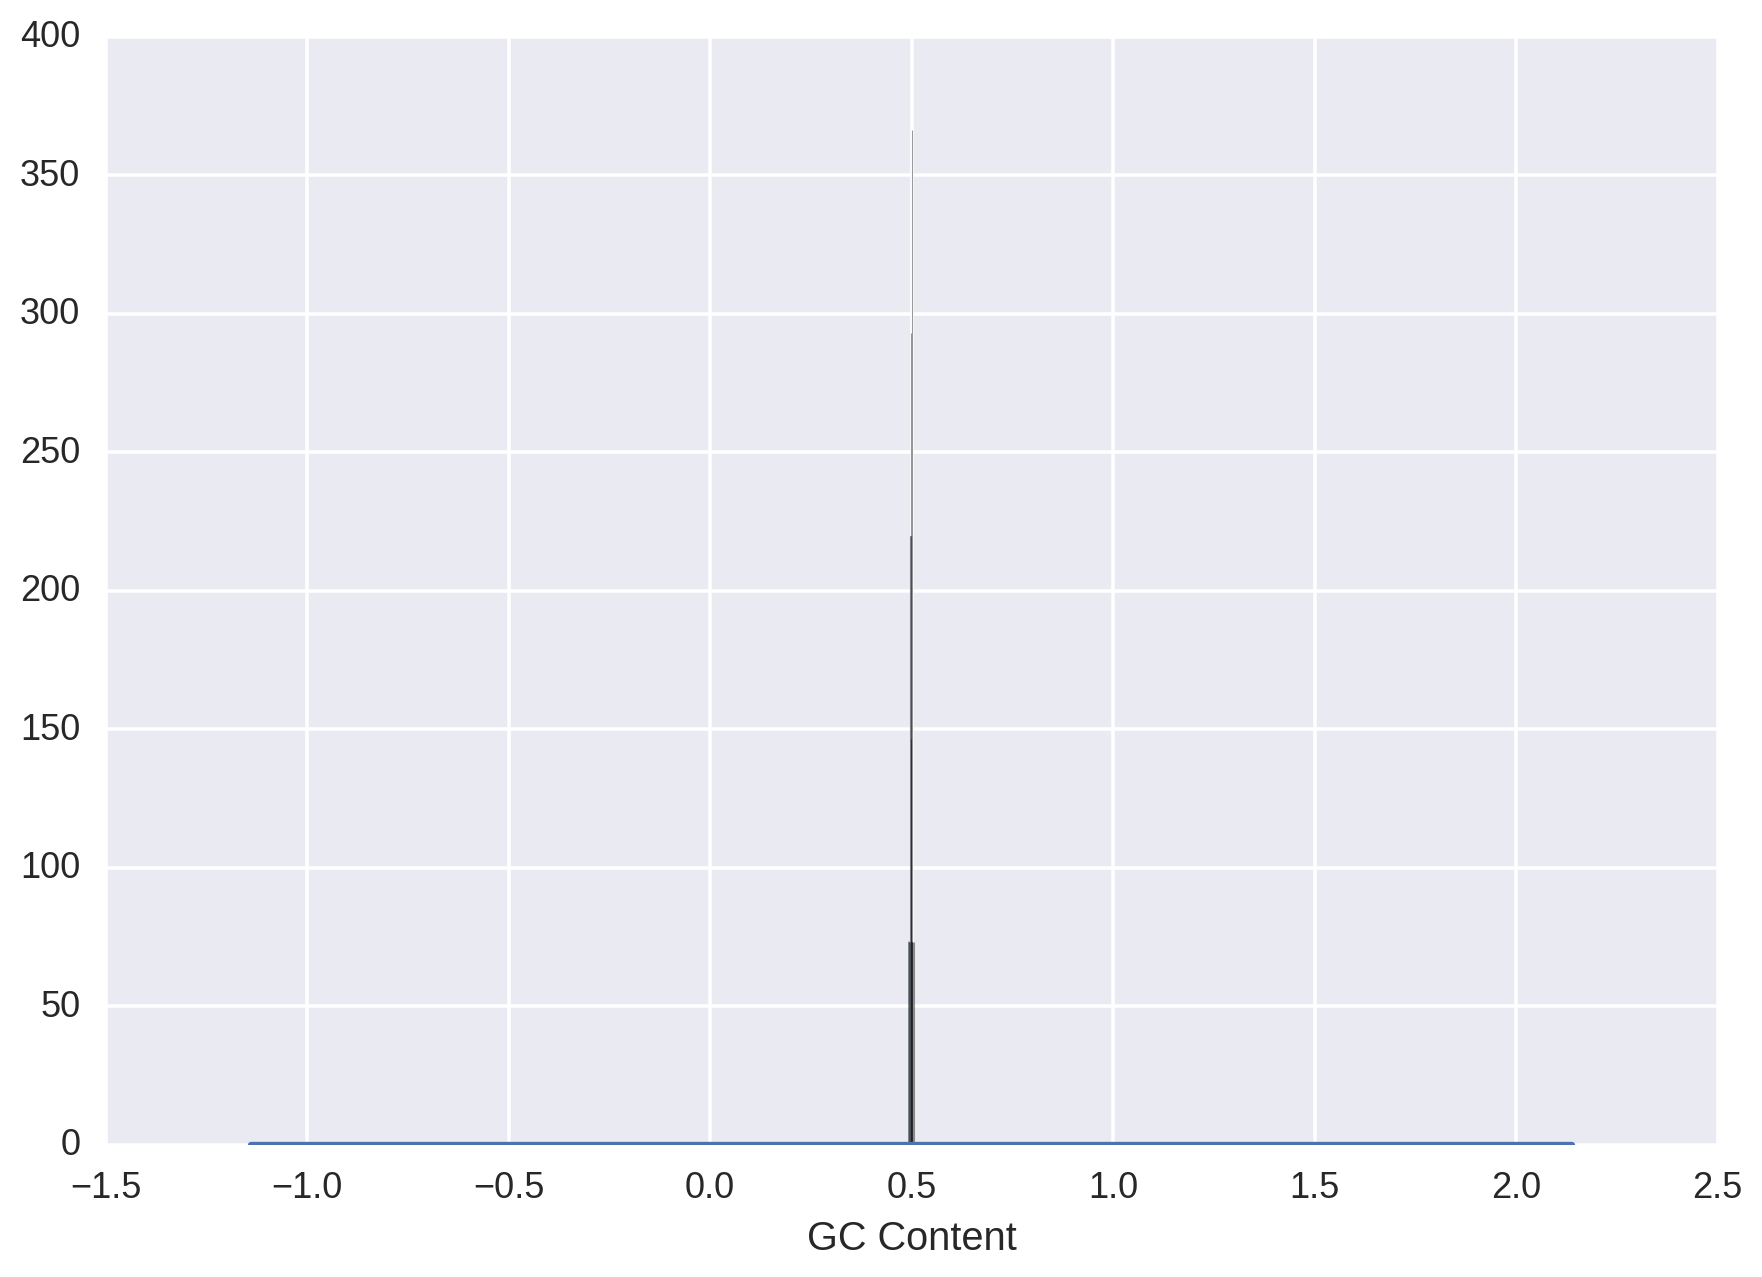

In [23]:
# plot distribution of uniquely mapped reads
sns.distplot(summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(summary_frame['uniquelyMappedReads'], bins=20, kde=False)
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(summary_frame['totalReads'], y=summary_frame['uniquelyMappedReads'])
plt.xlabel('totalReads')
plt.ylabel('uniquelyMappedReads')
plt.show()

sns.distplot(summary_frame['averageTagsPerPosition'], bins=20)
plt.xlabel('Clonality')
plt.show()

sns.distplot(summary_frame['averageFragmentGCcontent'], bins=20)
plt.xlabel('GC Content')
plt.show()



### Filter Samples According to Mapping Quality

In [24]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.00
uniquelyMappedReadThreshold = 1000000
pbcThreshold=0.0
gcThreshold=0.10
clonalityThreshold = 4.0
# spotThreshold = 0.005

filtered_summary_frame = summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

filtered_summary_frame = filtered_summary_frame[np.abs(filtered_summary_frame['averageFragmentGCcontent'] - 0.5) <=gcThreshold]

filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['averageTagsPerPosition'] <= clonalityThreshold]


# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
simpleTreatmentCombos = filtered_summary_frame["strain"].values + '_' +filtered_summary_frame["simpleTreatment"].values
for simpleNameRoot in simpleTreatmentCombos:
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot]))
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames
sampleName_simpleName_dict = dict(zip(filtered_summary_frame["sampleName"], filtered_summary_frame["simplifiedName"])) # {newName:simplifiedName}
simpleName_sampleName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["sampleName"])) # {simplifiedName:newName}

originalName_simpleName_dict = dict(zip(filtered_summary_frame["originalName"], filtered_summary_frame["simplifiedName"]))
simpleName_originalName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["originalName"])) 

filtered_summary_frame.to_csv('filtered_qc_metrics.tsv', sep='\t', index=False)

Number of Samples: 21
Number of discarded samples: 0
Number of Samples remaining after filtering: 21


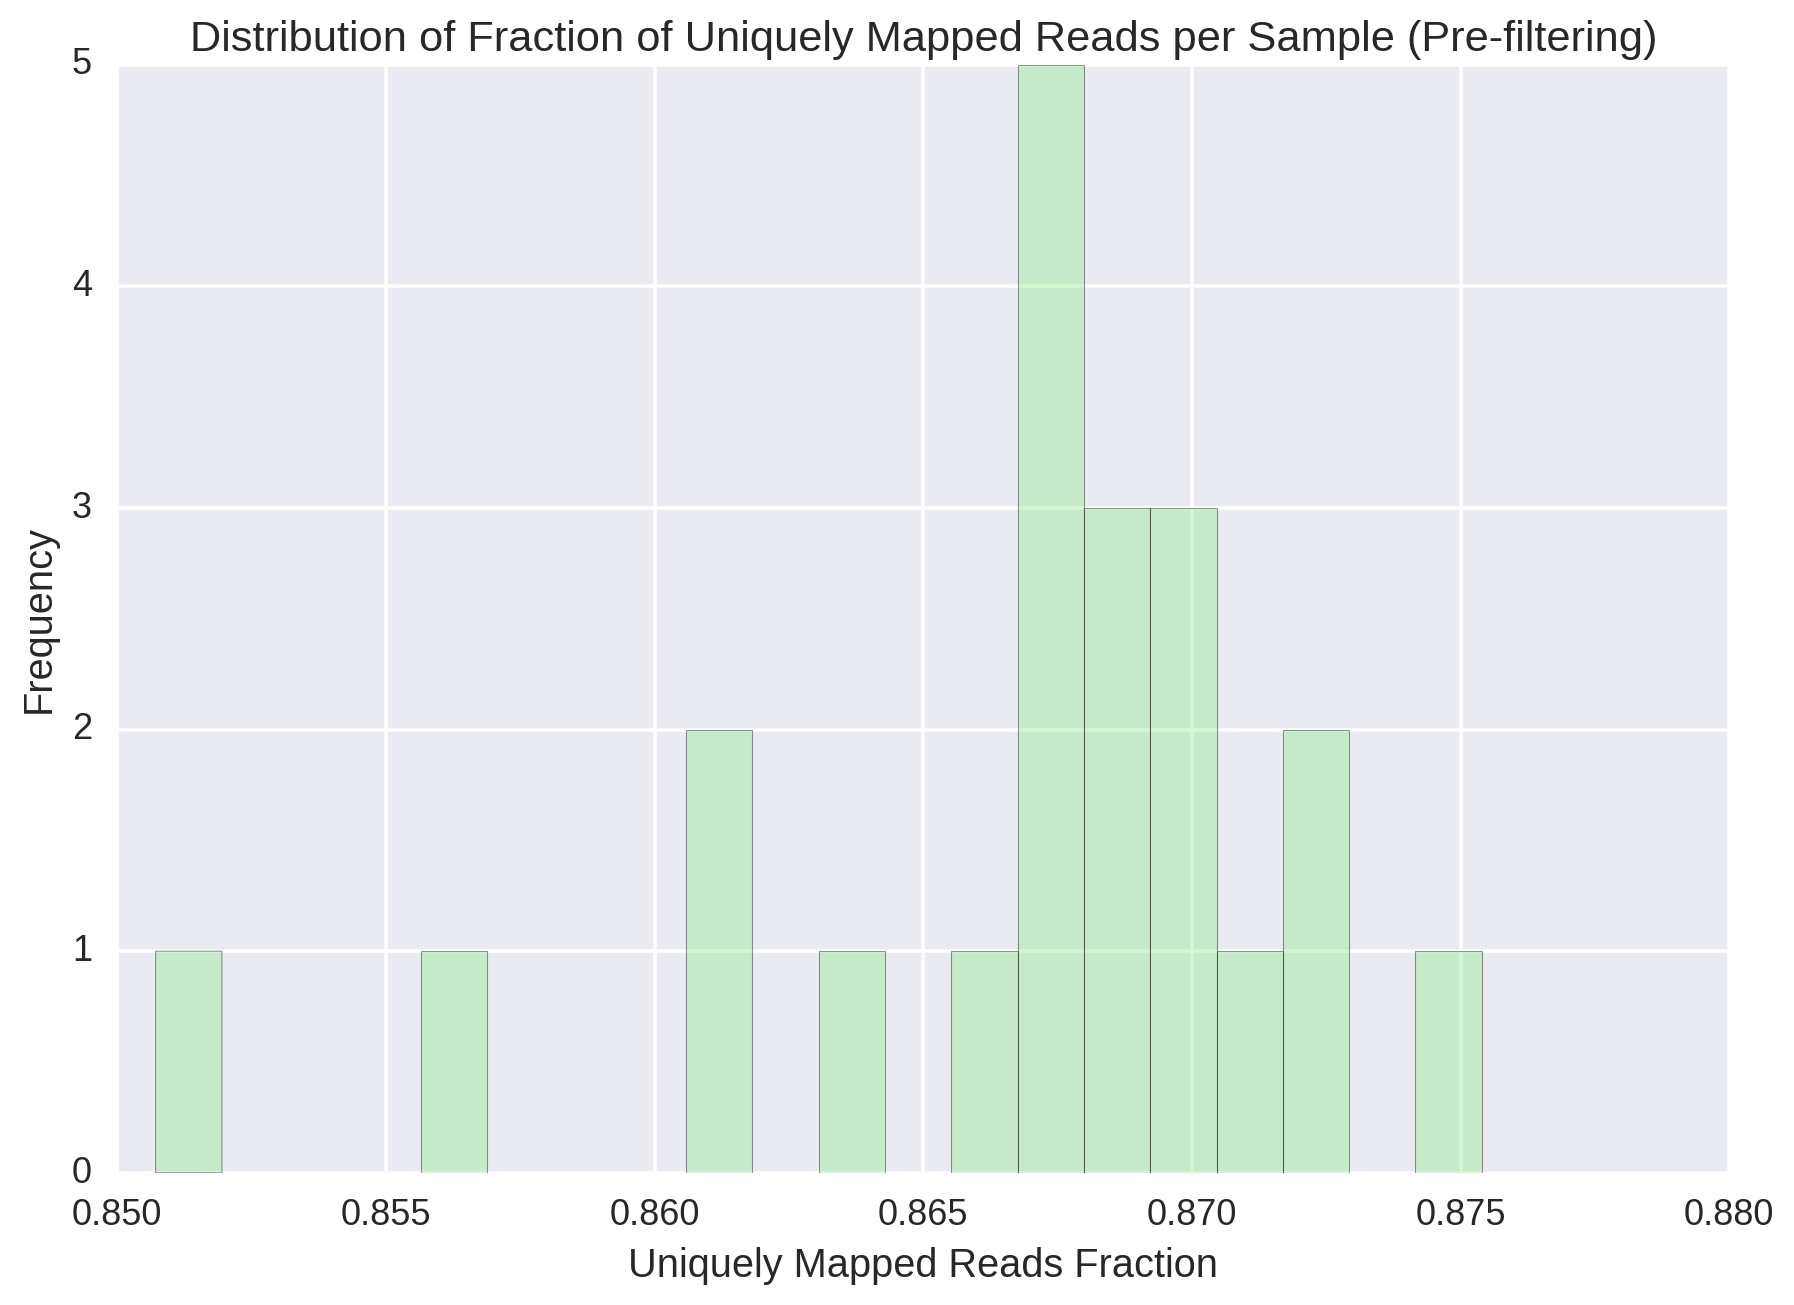

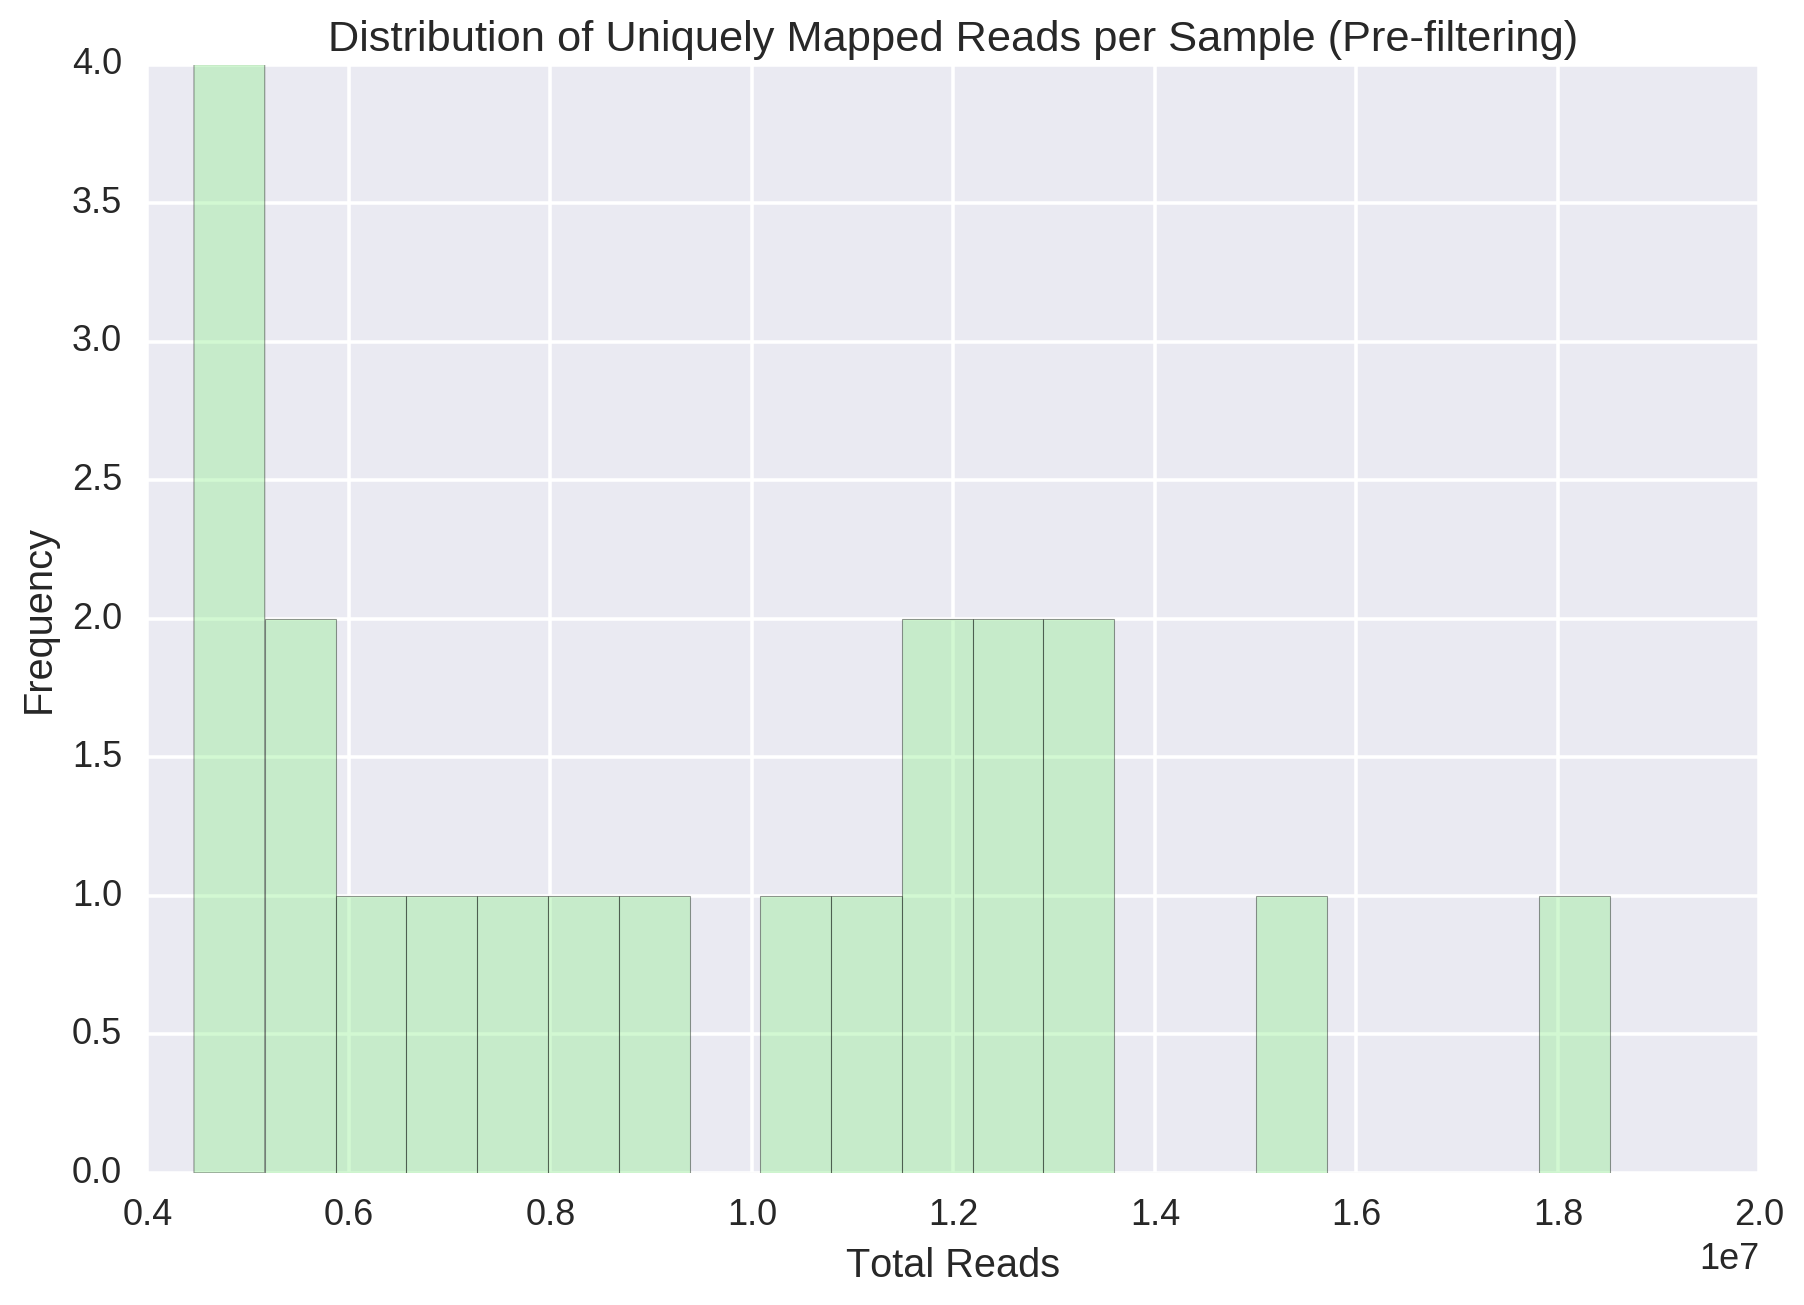

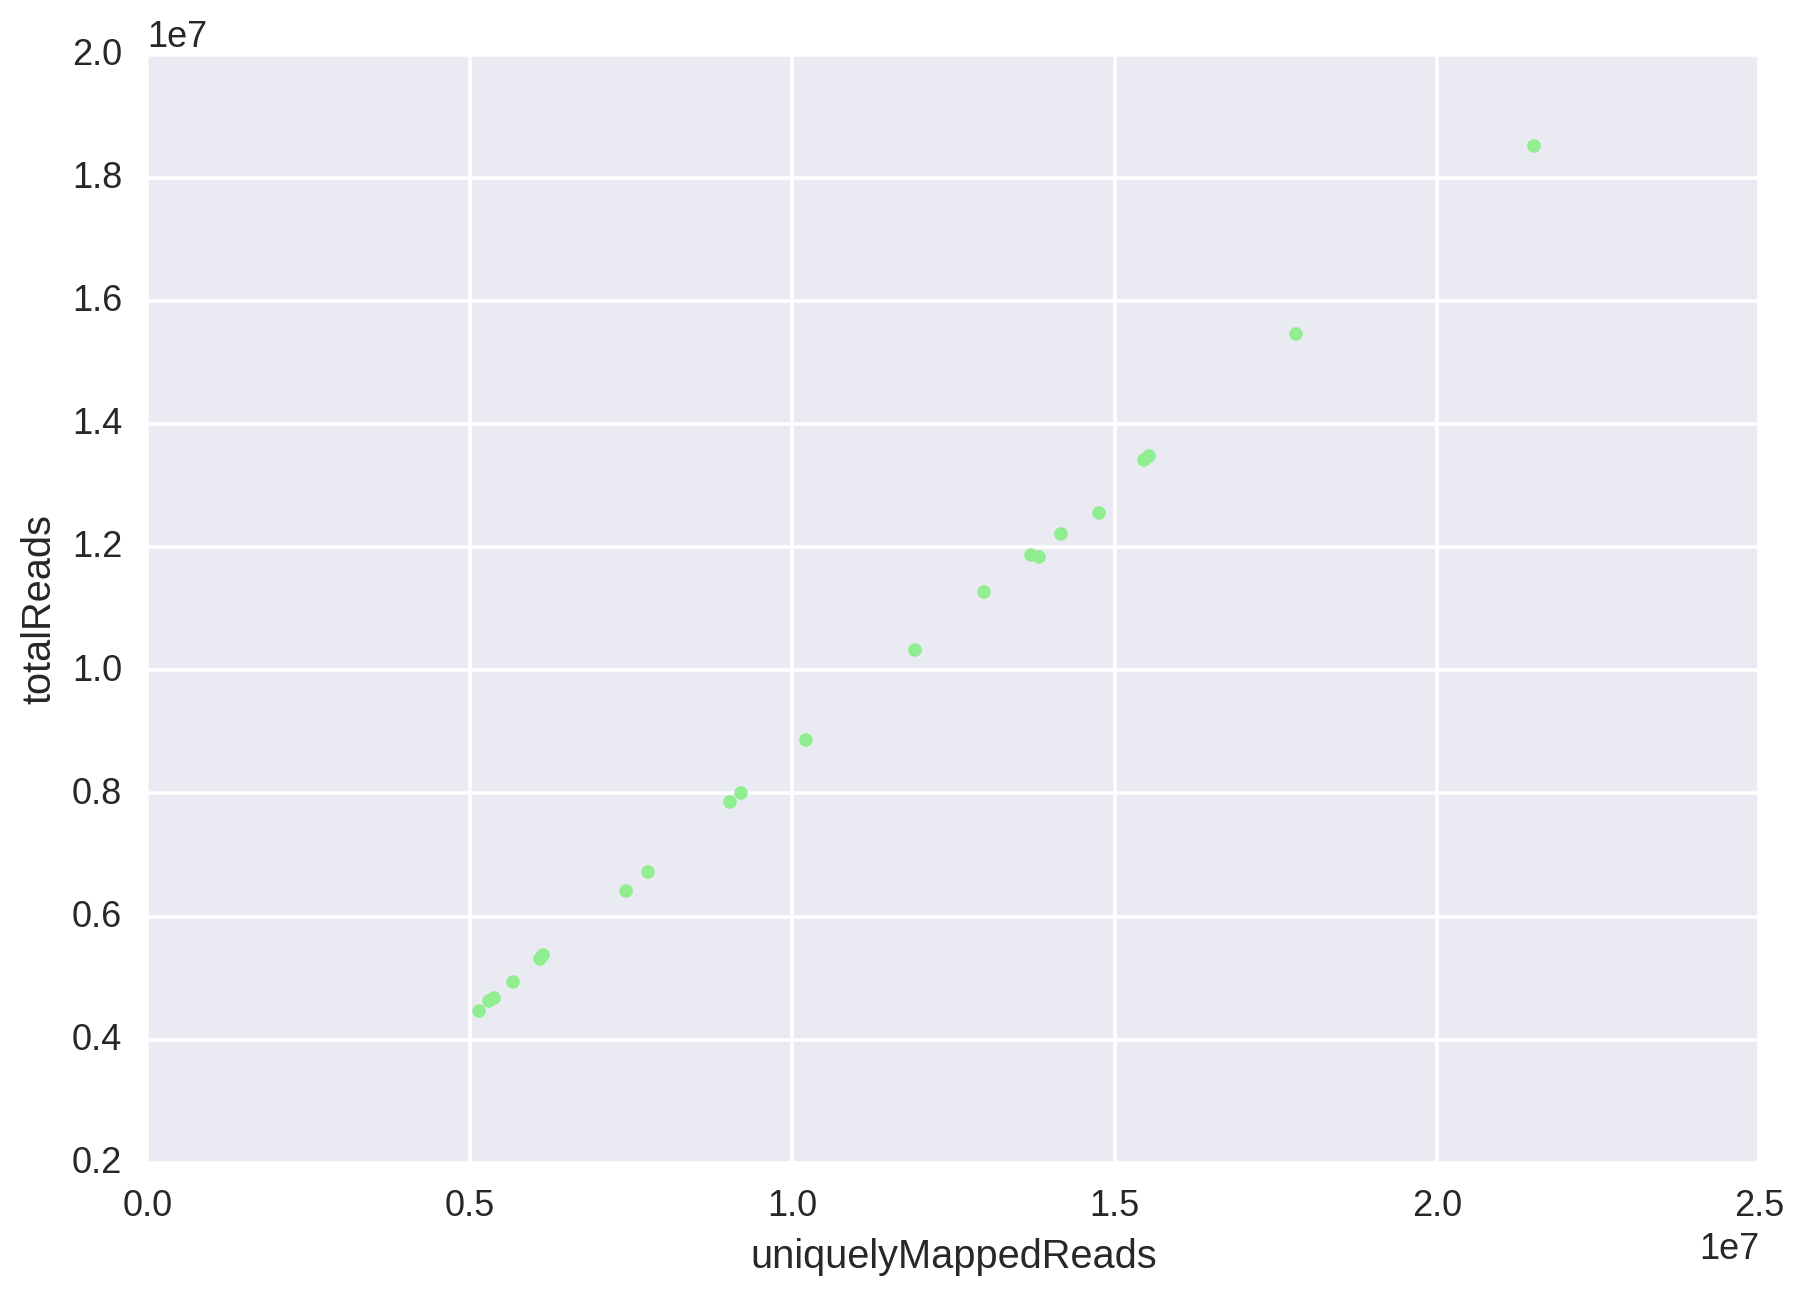

In [25]:
sns.distplot(filtered_summary_frame['uniquelyMappedFraction'], bins=20, kde=False, color='lightgreen')
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(filtered_summary_frame['uniquelyMappedReads'], bins=20, kde=False, color='lightgreen')
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(filtered_summary_frame['totalReads'], y=filtered_summary_frame['uniquelyMappedReads'], color='lightgreen')
plt.ylabel('totalReads')
plt.xlabel('uniquelyMappedReads')
plt.show()







## Calculate Tag Counts and RPKM

In [30]:
# %%capture
filteredTagDirectories = ' '.join([tagDirPath +x for x in filtered_summary_frame['originalName']])
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d $filteredTagDirectories >rpkm_thiomac.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories >raw_thiomac.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -d $filteredTagDirectories >normed_thiomac.tsv

	Tag Directories:
		/home/jenhan/analysis/dhcr24_analysis//tag_directories_thiomac/ThioMac_RNA_1um-DMHCA-1_Mim9_EDM_15-07-16
		/home/jenhan/analysis/dhcr24_analysis//tag_directories_thiomac/ThioMac_RNA_1um-DMHCA-3_Mim9_EDM_15-07-16
		/home/jenhan/analysis/dhcr24_analysis//tag_directories_thiomac/ThioMac_RNA_1um-DMHCA-2_Mim9_EDM_15-07-16
		/home/jenhan/analysis/dhcr24_analysis//tag_directories_thiomac/ThioMac_RNA_10um-Des-1_Mim9_EDM_15-07-16
		/home/jenhan/analysis/dhcr24_analysis//tag_directories_thiomac/ThioMac_RNA_30um-Des-1_Mim9_EDM_15-07-16
		/home/jenhan/analysis/dhcr24_analysis//tag_directories_thiomac/ThioMac_RNA_10um-Des-3_Mim9_EDM_15-07-16
		/home/jenhan/analysis/dhcr24_analysis//tag_directories_thiomac/ThioMac_RNA_30um-Des-2_Mim9_EDM_15-07-16
		/home/jenhan/analysis/dhcr24_analysis//tag_directories_thiomac/ThioMac_RNA_10um-Des-2_Mim9_EDM_15-07-16
		/home/jenhan/analysis/dhcr24_analysis//tag_directories_thiomac/ThioMac_RNA_30um-Des-3_Mim9_EDM_15-07-16
		/home/jenhan/analysis/d

In [31]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm_thiomac.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]

# read in tag counts
reads_frame = pd.read_csv("normed_thiomac.tsv",sep="\t")
columns = reads_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
reads_frame.columns = columns  
reads_frame['gene'] = [x.split("|")[0] for x in reads_frame['Annotation/Divergence']]
columns = list(reads_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
reads_frame = reads_frame[columns]

raw_frame = pd.read_csv("raw_thiomac.tsv",sep="\t")
columns = raw_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
raw_frame.columns = columns  
raw_frame['gene'] = [x.split("|")[0] for x in raw_frame['Annotation/Divergence']]
columns = list(raw_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
raw_frame = raw_frame[columns]

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))
refseq_gene_mapping.update(dict(zip(reads_frame['refseq'].values, [x.split("|")[0] for x in reads_frame['Annotation/Divergence']])))
gene_refseq_mapping.update(dict(zip([x.split("|")[0] for x in reads_frame['Annotation/Divergence']], reads_frame['refseq'].values)))
refseq_gene_mapping.update(dict(zip(raw_frame['refseq'].values, [x.split("|")[0] for x in raw_frame['Annotation/Divergence']])))
gene_refseq_mapping.update(dict(zip([x.split("|")[0] for x in raw_frame['Annotation/Divergence']], raw_frame['refseq'].values)))




# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame['originalName'].values]]
columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 1.0]

filtered_reads_frame = reads_frame[[x for x in reads_frame.columns if x in filtered_summary_frame['originalName'].values]]
columns = [originalName_simpleName_dict[x] for x in filtered_reads_frame.columns.values]
filtered_reads_frame.columns =columns 
filtered_reads_frame.index = reads_frame.refseq.values


                                   
# create frame that's easier to use with factor plots
pivoting_frame = filtered_rpkm_frame.transpose()
_refseq = []
_gene = []
_rpkm = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(filtered_summary_frame['simpleTreatment'].values) * pivoting_frame.shape[1]
for refseq in pivoting_frame.columns:
    gene = refseq_gene_mapping[refseq]
    for rpkm in pivoting_frame[refseq].values:
        _rpkm.append(rpkm)
        _refseq.append(refseq)
        _gene.append(gene.upper())
filtered_rpkm_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'rpkm': _rpkm,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
del pivoting_frame
        
filtered_rpkm_plottingFrame_log = filtered_rpkm_plottingFrame.copy()
filtered_rpkm_plottingFrame_log['rpkm'] = np.log2(filtered_rpkm_plottingFrame.rpkm)

pivoting_frame = filtered_reads_frame.transpose()
_refseq = []
_gene = []
_reads = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(filtered_summary_frame['simpleTreatment'].values) * pivoting_frame.shape[1]
for refseq in pivoting_frame.columns:
    gene = refseq_gene_mapping[refseq]
    for rpkm in pivoting_frame[refseq].values:
        _reads.append(rpkm)
        _refseq.append(refseq)
        _gene.append(gene.upper())
filtered_reads_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'reads': _reads,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
del pivoting_frame
        





## Run IDR

In [32]:
# %%capture
sampleColumns = rpkm_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(summary_frame['originalName'], summary_frame['simpleTreatment']))
conditions = " ".join([originalName_simpleTreatment_dict[x] for x in sampleColumns])
!python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm_thiomac.tsv $idrDirectory $conditions

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Output files will be written to: /home/jenhan/analysis/dhcr24_analysis//idr_thiomac/
Using the following IDR threshold: 0.05
Performing IDR analysis using the following columns and conditions:
/home/jenhan/analysis/dhcr24_analysis//tag_directories_thiomac/ThioMac_RNA_1um-DMHCA-1_Mim9_EDM_15-07-16 reads FPKM 	 DMHCA
/home/jenhan/analysis/dhcr24_analysis//tag_directories_thiomac/ThioMac_RNA_1um-DMHCA-3_Mim9_EDM_15-07-16 reads FPKM 	 DMHCA
/home/jenhan/analysis/dhcr24_analysis//tag_directories_thiomac/ThioMac_RNA_1um-DMHCA-2_Mim9_EDM_15-07-16 reads FPKM 	 DMHCA
/home/jenhan/analysis/dhcr24_analysis//tag_directories_thiomac/ThioMac_RNA_10um-Des-1_Mim9_EDM_15-07-16 reads FPKM 	 Des
/home/jenhan/analysis/dhcr24_analysis//tag_directories_thiomac/ThioMac_RN

## Differential Expression Analysis

In [33]:
%%capture
# use Homer to call differentially expressed genes with replicates
sample_condition_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['simpleTreatment']))
samples = raw_frame.columns[9:].values

conditions = " ".join([sample_condition_dict[x] for x in samples])
! getDiffExpression.pl raw_thiomac.tsv $conditions > homer_diffExpresion_thiomac.tsv

In [34]:
diffExpression_frame = pd.read_csv('homer_diffExpresion_thiomac.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0] = 'refseq'
columns = [''.join(x.split('/')[-2:]) if '/' in x else x for x in columns]
diffExpression_frame.columns = columns
new_columns = [] 
for col in columns:
    if " vs. " in col:
        new_columns.append(col)
new_columns.insert(0,'refseq')
diffExpression_frame = diffExpression_frame[new_columns]
diffExpression_frame.index = diffExpression_frame['refseq'].values

In [35]:
refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x for x in rpkm_frame['Annotation/Divergence']]))
intersecting_refseqs = None
for p in os.listdir(idrDirectory):
    if "idrUnion" in p:
        with open(idrDirectory + '/' +p) as f:
            data = f.readlines()
        refseqs = []
        for line in data[1:]:
            tokens = line.split("\t")
            refseq = tokens[0]
            refseqs.append(refseq)
        if intersecting_refseqs == None:
            intersecting_refseqs = set(refseqs)
        else:
            intersecting_refseqs = intersecting_refseqs.intersection(set(refseqs))
        print(len(intersecting_refseqs))

idr_diffExpression_frame = diffExpression_frame[diffExpression_frame["refseq"].isin(intersecting_refseqs)]
idr_diffExpression_frame['gene name'] = [refseq_gene_mapping[x] for x in idr_diffExpression_frame['refseq'].values]
idr_diffExpression_frame.to_csv("homer_diffExpresion_intersection_idr.tsv",sep='\t', index = False)      

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]))



14846
13462
12877
12691
12520
12494


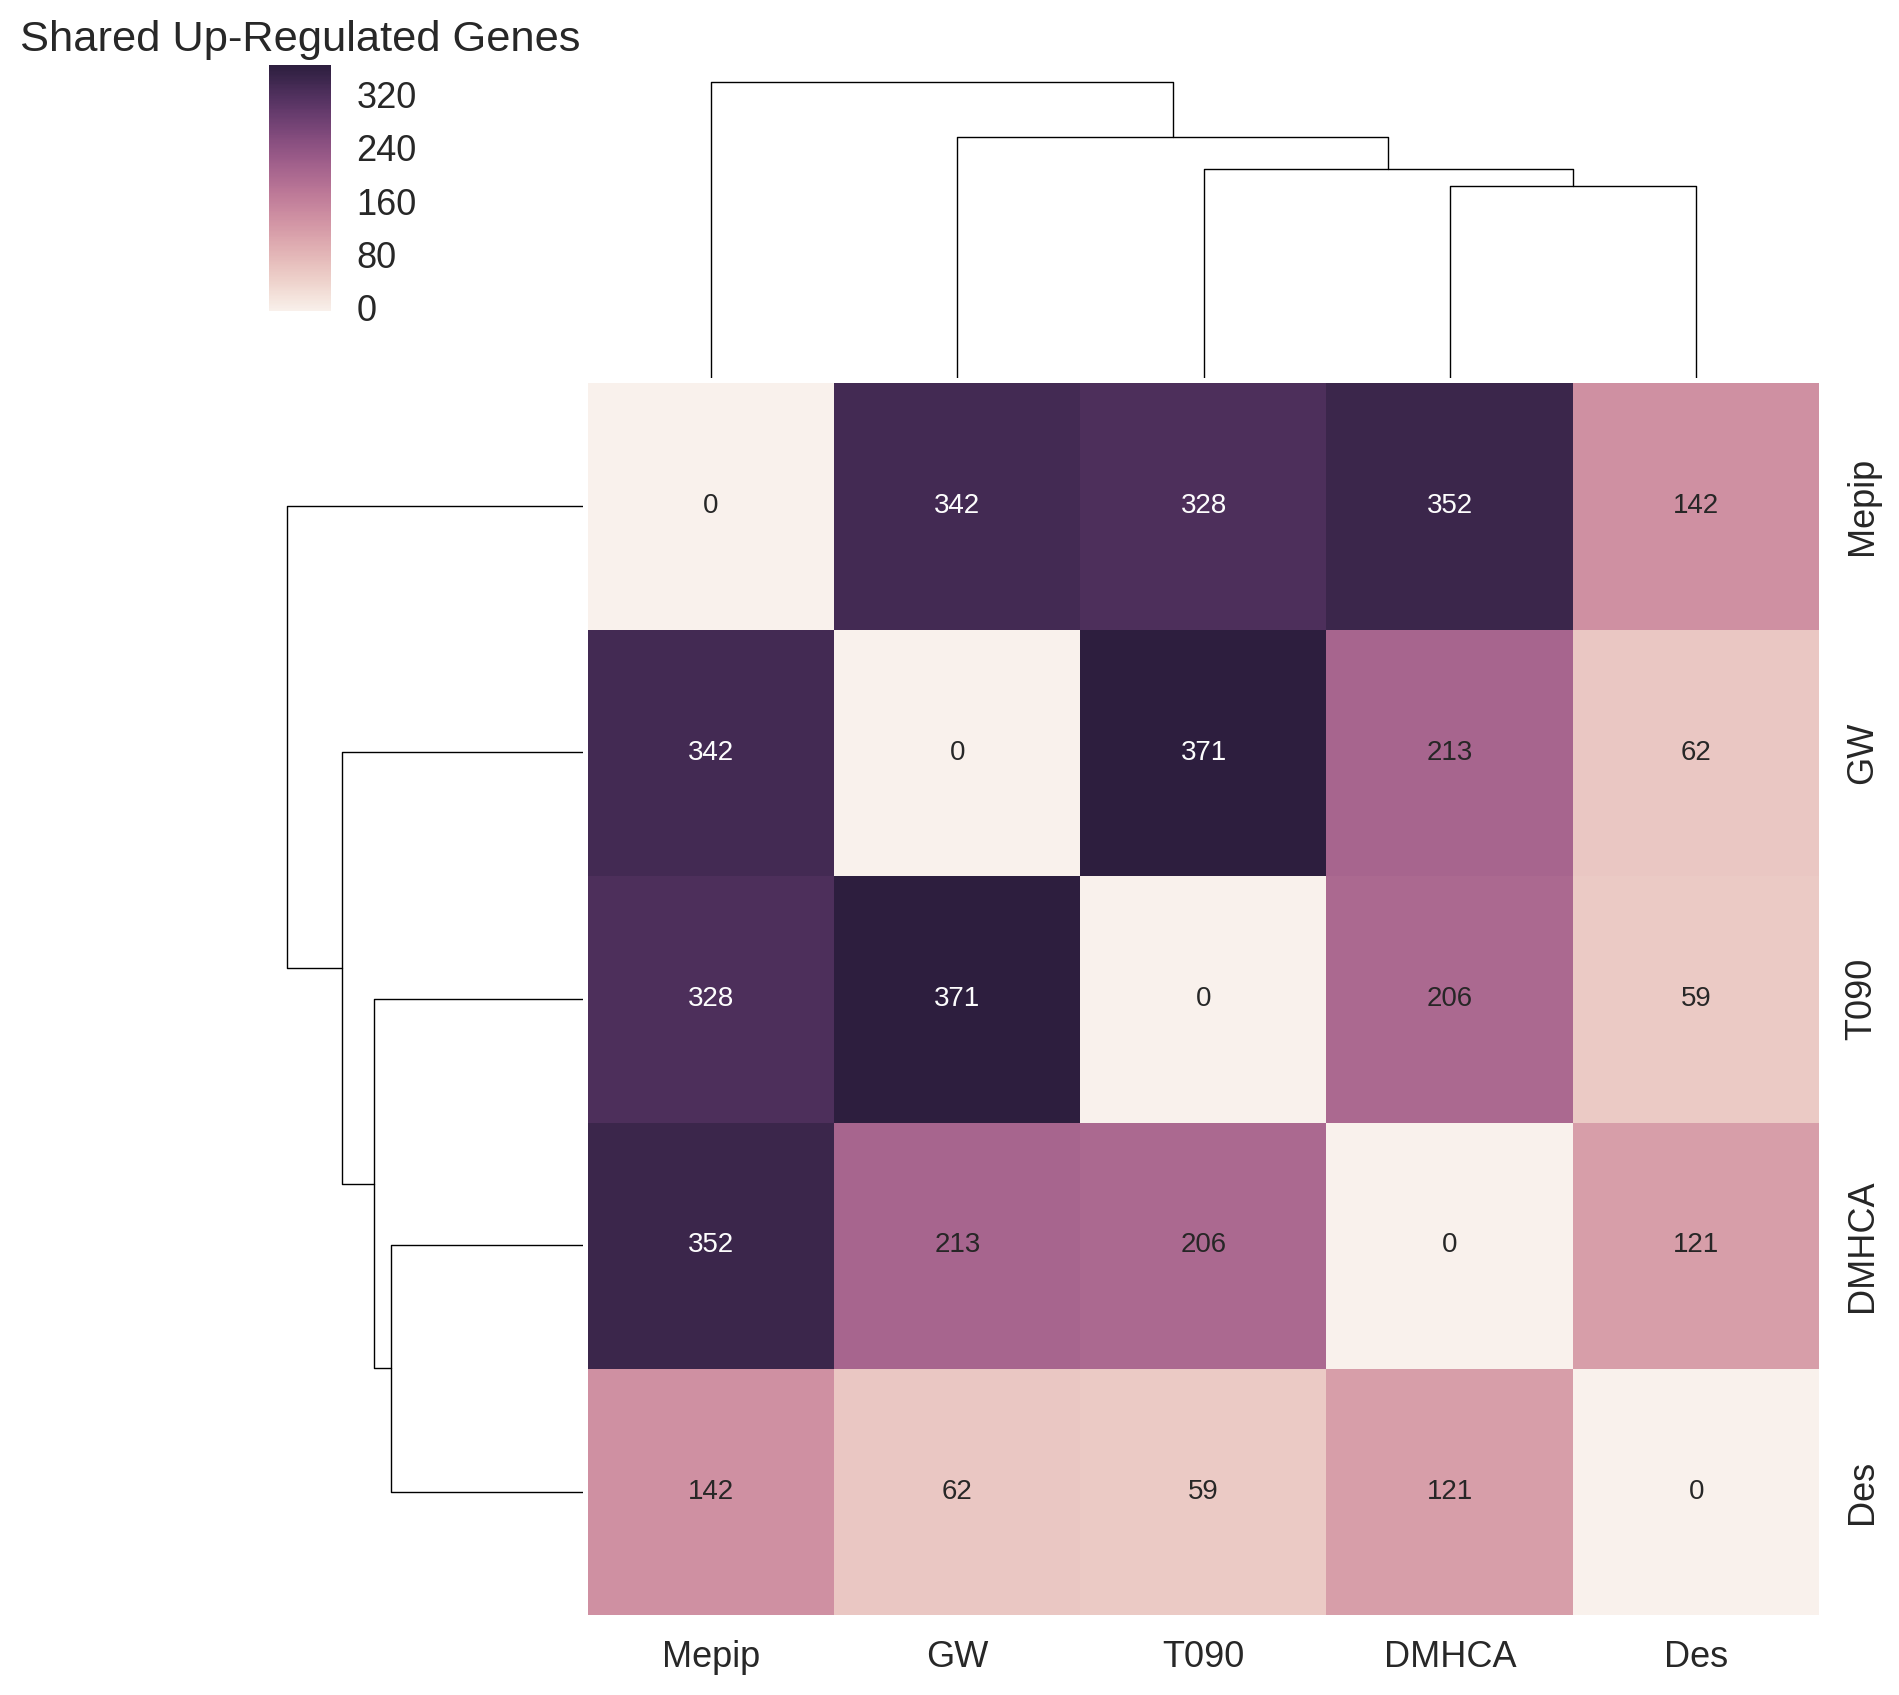

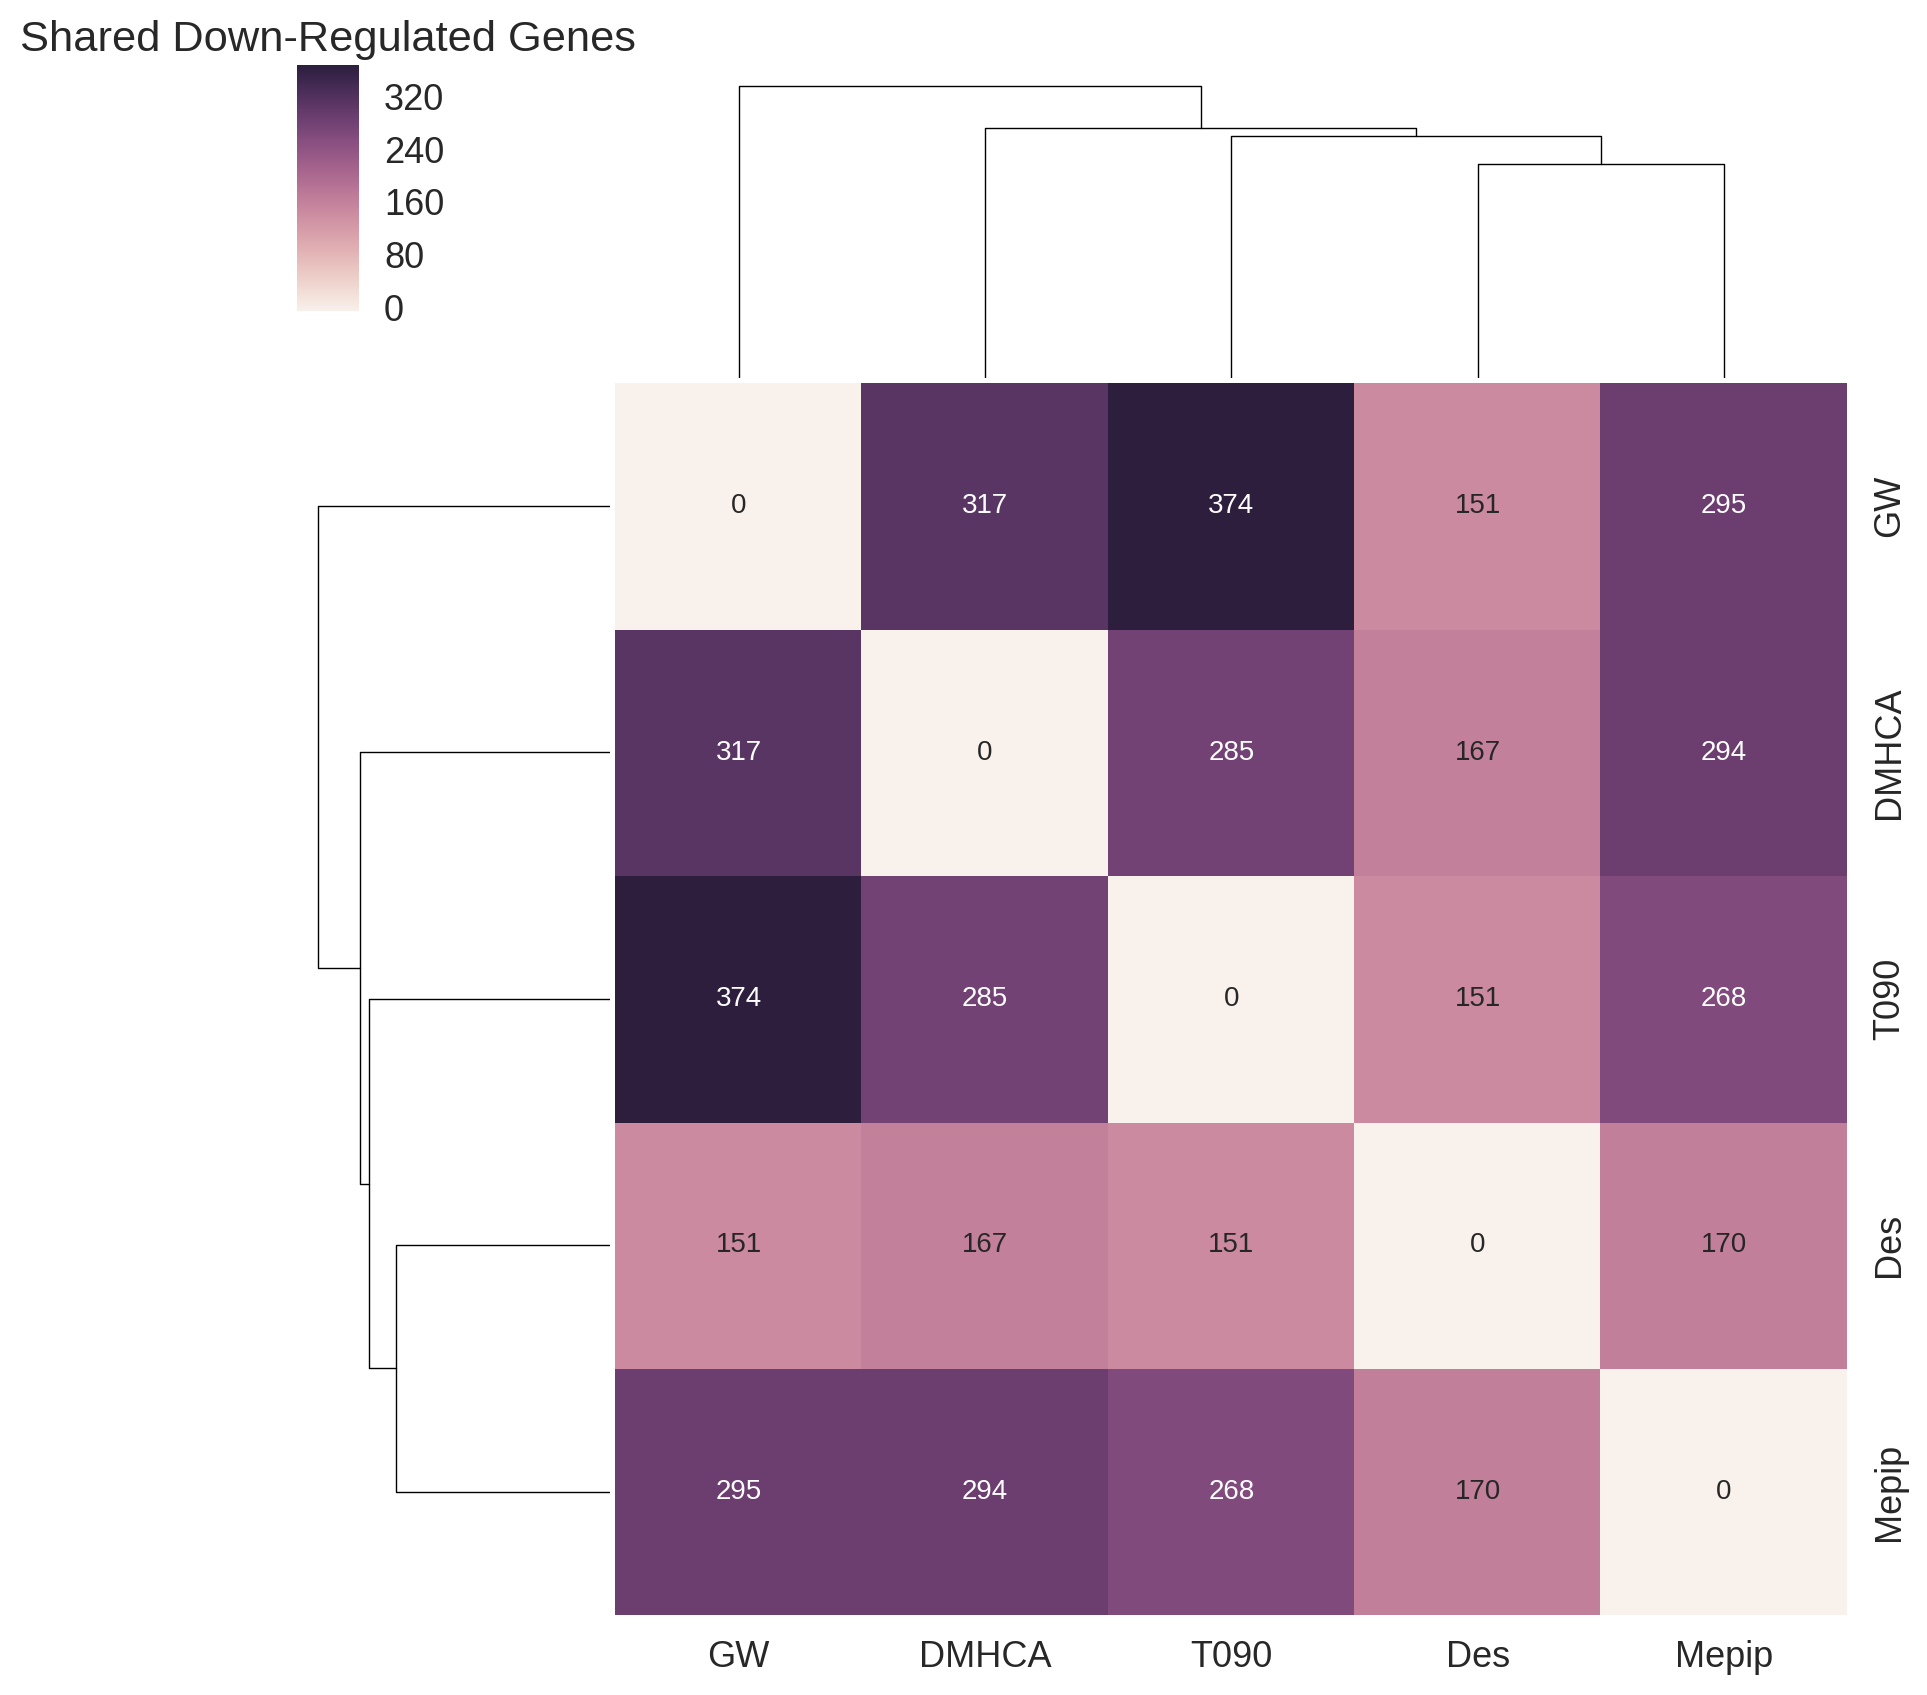

In [36]:
# get up and down regulated genes versus vehicle for each condition
p_threshold = 0.005
fdr_threshold = 0.005
treatments = sorted(list(set(filtered_summary_frame["simpleTreatment"].values)))
treatments.remove('Vehicle')
treatment_index_dict = {treatments[x]:x for x in range(len(treatments))}


treatment_upRefseqs = {x:[] for x in treatments}
treatment_downRefseqs = {x:[] for x in treatments}

edgeR_cols = ['logFC', 'logCPM', 'PValue', 'FDR']
for t in treatments:
    header = t + ' vs. Vehicle '
    currentVals = diffExpression_frame[[header+x for x in edgeR_cols]]
    currentVals = currentVals[(currentVals[header + 'PValue'] < p_threshold) & (currentVals[header + 'FDR'] < fdr_threshold)]
    upRegulated = currentVals[currentVals[header + 'logFC'] > 0].index.values
    downRegulated = currentVals[currentVals[header + 'logFC'] < 0].index.values

    treatment_upRefseqs[t] = upRegulated
    treatment_downRefseqs[t] = downRegulated

# create heat map visualization for how many differentially expressed genes are shared
up_matrix = np.zeros((len(treatments), len(treatments)))
down_matrix = np.zeros((len(treatments), len(treatments)))
for i in range(len(treatments) - 1):
    for j in range(i+1, len(treatments)):
        treatment1 = treatments[i]
        treatment2 = treatments[j]
        ind1 = treatment_index_dict[treatment1]
        ind2 = treatment_index_dict[treatment2]
        num_intersecting_up = len(set(treatment_upRefseqs[treatment1]).intersection(set(treatment_upRefseqs[treatment2])))
        num_intersecting_down = len(set(treatment_downRefseqs[treatment1]).intersection(set(treatment_downRefseqs[treatment2])))
        up_matrix[ind1][ind2] = num_intersecting_up
        up_matrix[ind2][ind1] = num_intersecting_up
        down_matrix[ind1][ind2] = num_intersecting_down
        down_matrix[ind2][ind1] = num_intersecting_down

# # fill in diagonals
# for i in range(len(treatments)):
#         treatment = treatments[i]
#         ind = treatment_index_dict[treatment]
#         num_up = len(set(treatment_upRefseqs[treatment]))
#         num_down = len(set(treatment_downRefseqs[treatment]))

#         up_matrix[ind][ind] = num_up
#         down_matrix[ind][ind] = num_down


        
# convert matrices to data frames
up_frame = pd.DataFrame(up_matrix).astype(int)
up_frame.columns = treatments
up_frame.index = treatments

down_frame = pd.DataFrame(down_matrix).astype(int)
down_frame.columns = treatments
down_frame.index = treatments

sns.clustermap(up_frame, annot=True, fmt='d')
plt.title("Shared Up-Regulated Genes")
plt.show()

sns.clustermap(down_frame, annot=True, fmt='d')
plt.title("Shared Down-Regulated Genes")
plt.show()



In [38]:
from itertools import combinations
# make venn diagrams of doubles
!mkdir venn2
for comb in combinations(treatments,2):
    set_labels = []
    up_sets = []
    down_sets = []

    for t in comb:
        set_labels.append(t)
        up_sets.append(set(treatment_upRefseqs[t]))
        down_sets.append(set(treatment_downRefseqs[t]))
    venn2(up_sets, set_labels=set_labels)
    plt.title(' vs ' .join(set_labels) + 'Upregulated Genes')
    plt.savefig('./venn2/' + ' vs ' .join(set_labels) +'_up.pdf')
    plt.close()
    
    venn2(up_sets, set_labels=set_labels)
    plt.title(' vs ' .join(set_labels) + 'Downregulated Genes')
    plt.savefig('./venn2/' + ' vs ' .join(set_labels) +'_down.pdf')
    plt.close()

mkdir: cannot create directory ‘venn2’: File exists


/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:422: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [39]:
# make venn diagrams of doubles
!mkdir venn3
for comb in combinations(treatments,3):
    set_labels = []
    up_sets = []
    down_sets = []

    for t in comb:
        set_labels.append(t)
        up_sets.append(set(treatment_upRefseqs[t]))
        down_sets.append(set(treatment_downRefseqs[t]))
    venn3(up_sets, set_labels=set_labels)
    plt.title(' vs ' .join(set_labels) + 'Upregulated Genes')
    plt.savefig('./venn3/' + ' vs ' .join(set_labels) +'_up.pdf')
    plt.close()
    
    venn3(up_sets, set_labels=set_labels)
    plt.title(' vs ' .join(set_labels) + 'Downregulated Genes')
    plt.savefig('./venn3/' + ' vs ' .join(set_labels) +'_down.pdf')
    plt.close()

mkdir: cannot create directory ‘venn3’: File exists


/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:422: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [40]:
up_refseqs = set(treatment_upRefseqs[treatments[0]])
down_refseqs = set(treatment_downRefseqs[treatments[0]])

for t in treatment_upRefseqs:
    up_refseqs = up_refseqs.union(set(treatment_upRefseqs[t]))
    
for t in treatment_downRefseqs:
    down_refseqs = up_refseqs.union(set(treatment_upRefseqs[t]))
clustering_refseqs = up_refseqs.union(down_refseqs)
print("number of refseqs for clustering:", len(clustering_refseqs))

number of refseqs for clustering: 1985


In [41]:
data = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(clustering_refseqs)]

log_data = np.log2(filtered_rpkm_frame[filtered_rpkm_frame.index.isin(clustering_refseqs)] + 1)
log_data[log_data<-3] = -3

log_data[log_data>9] = 9

log_data = log_data.fillna(0)

(-5, 15)

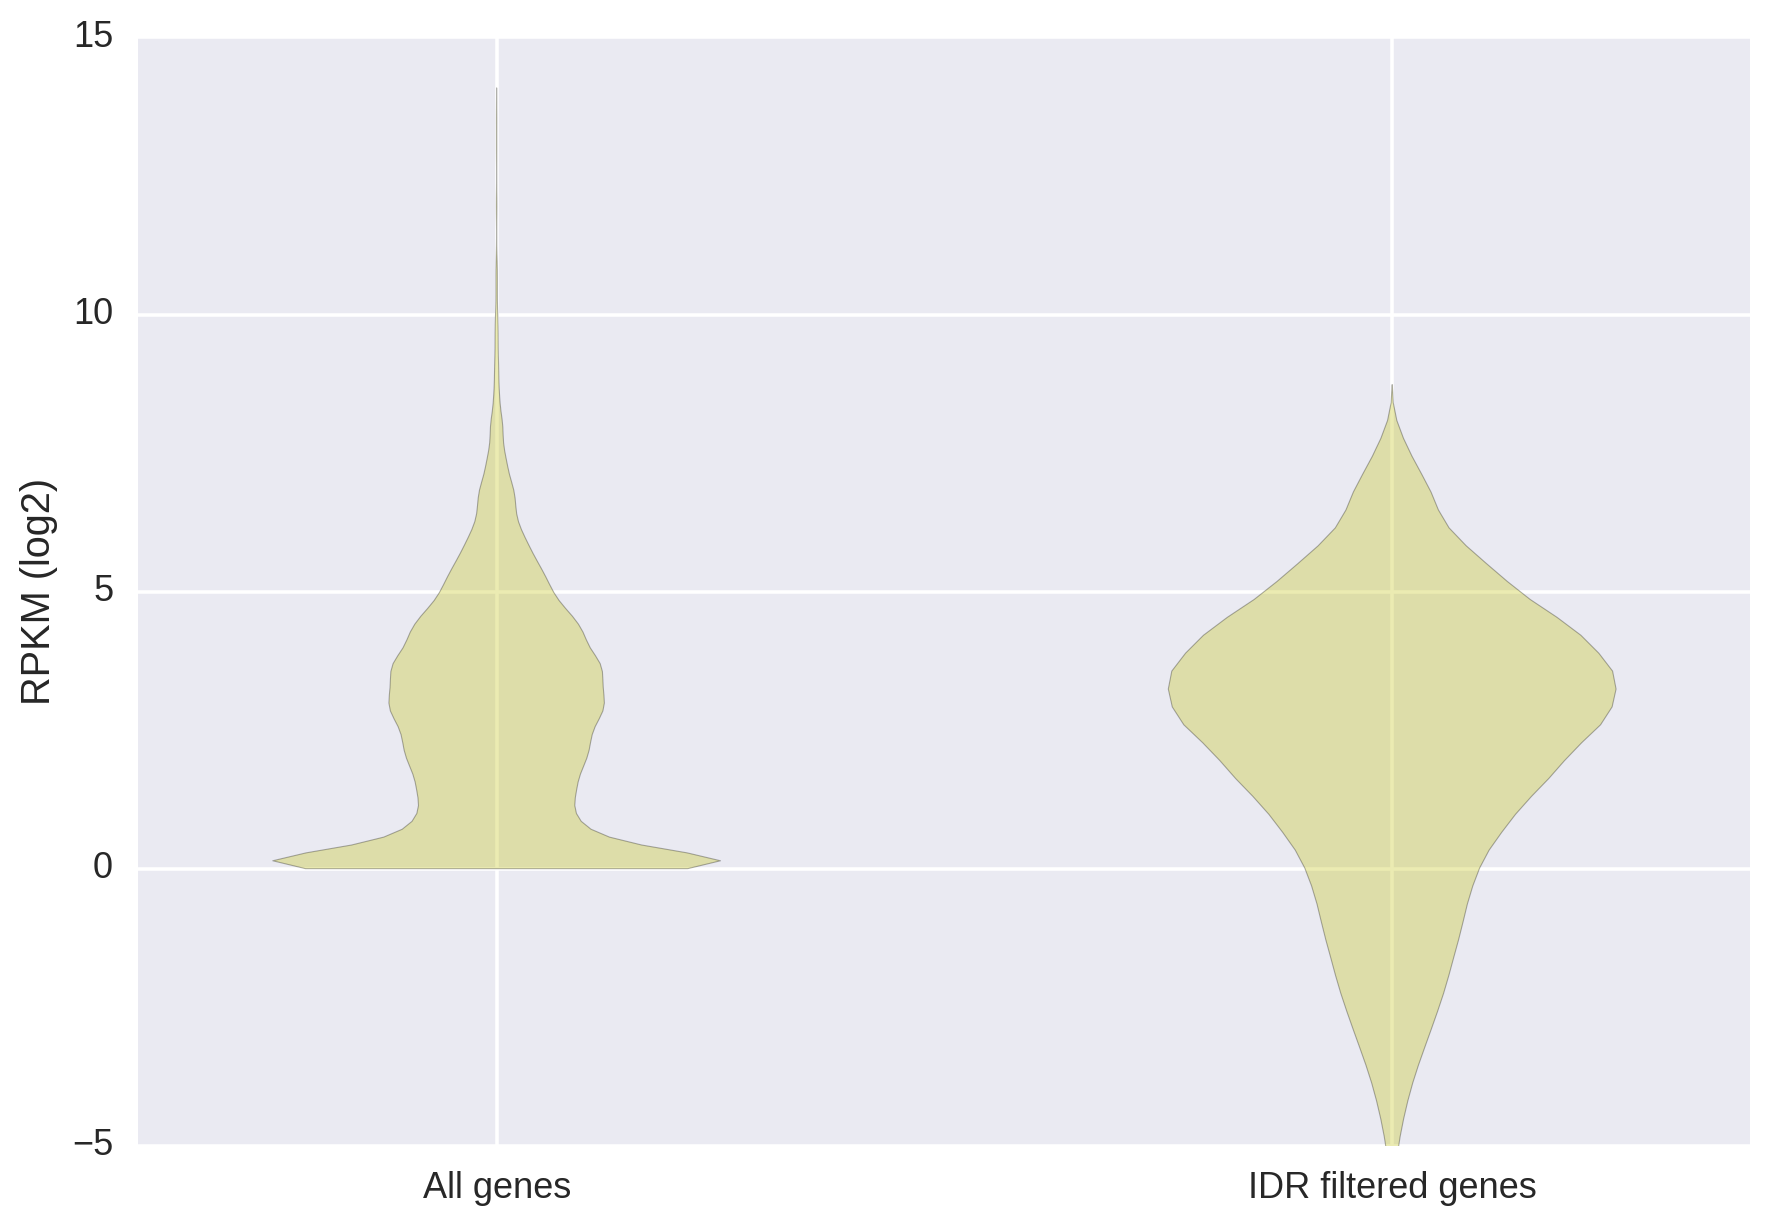

In [42]:
plt.violinplot([np.log2(filtered_rpkm_frame.values.flatten() + 1), 
                       np.log2(filtered_rpkm_frame[filtered_rpkm_frame.index.isin(intersecting_refseqs)].values.flatten() + 0.0000001)
                       ], showextrema=False)
plt.xticks(range(1,3), ['All genes', 'IDR filtered genes'])
plt.ylabel('RPKM (log2)')
plt.ylim([-5,15])

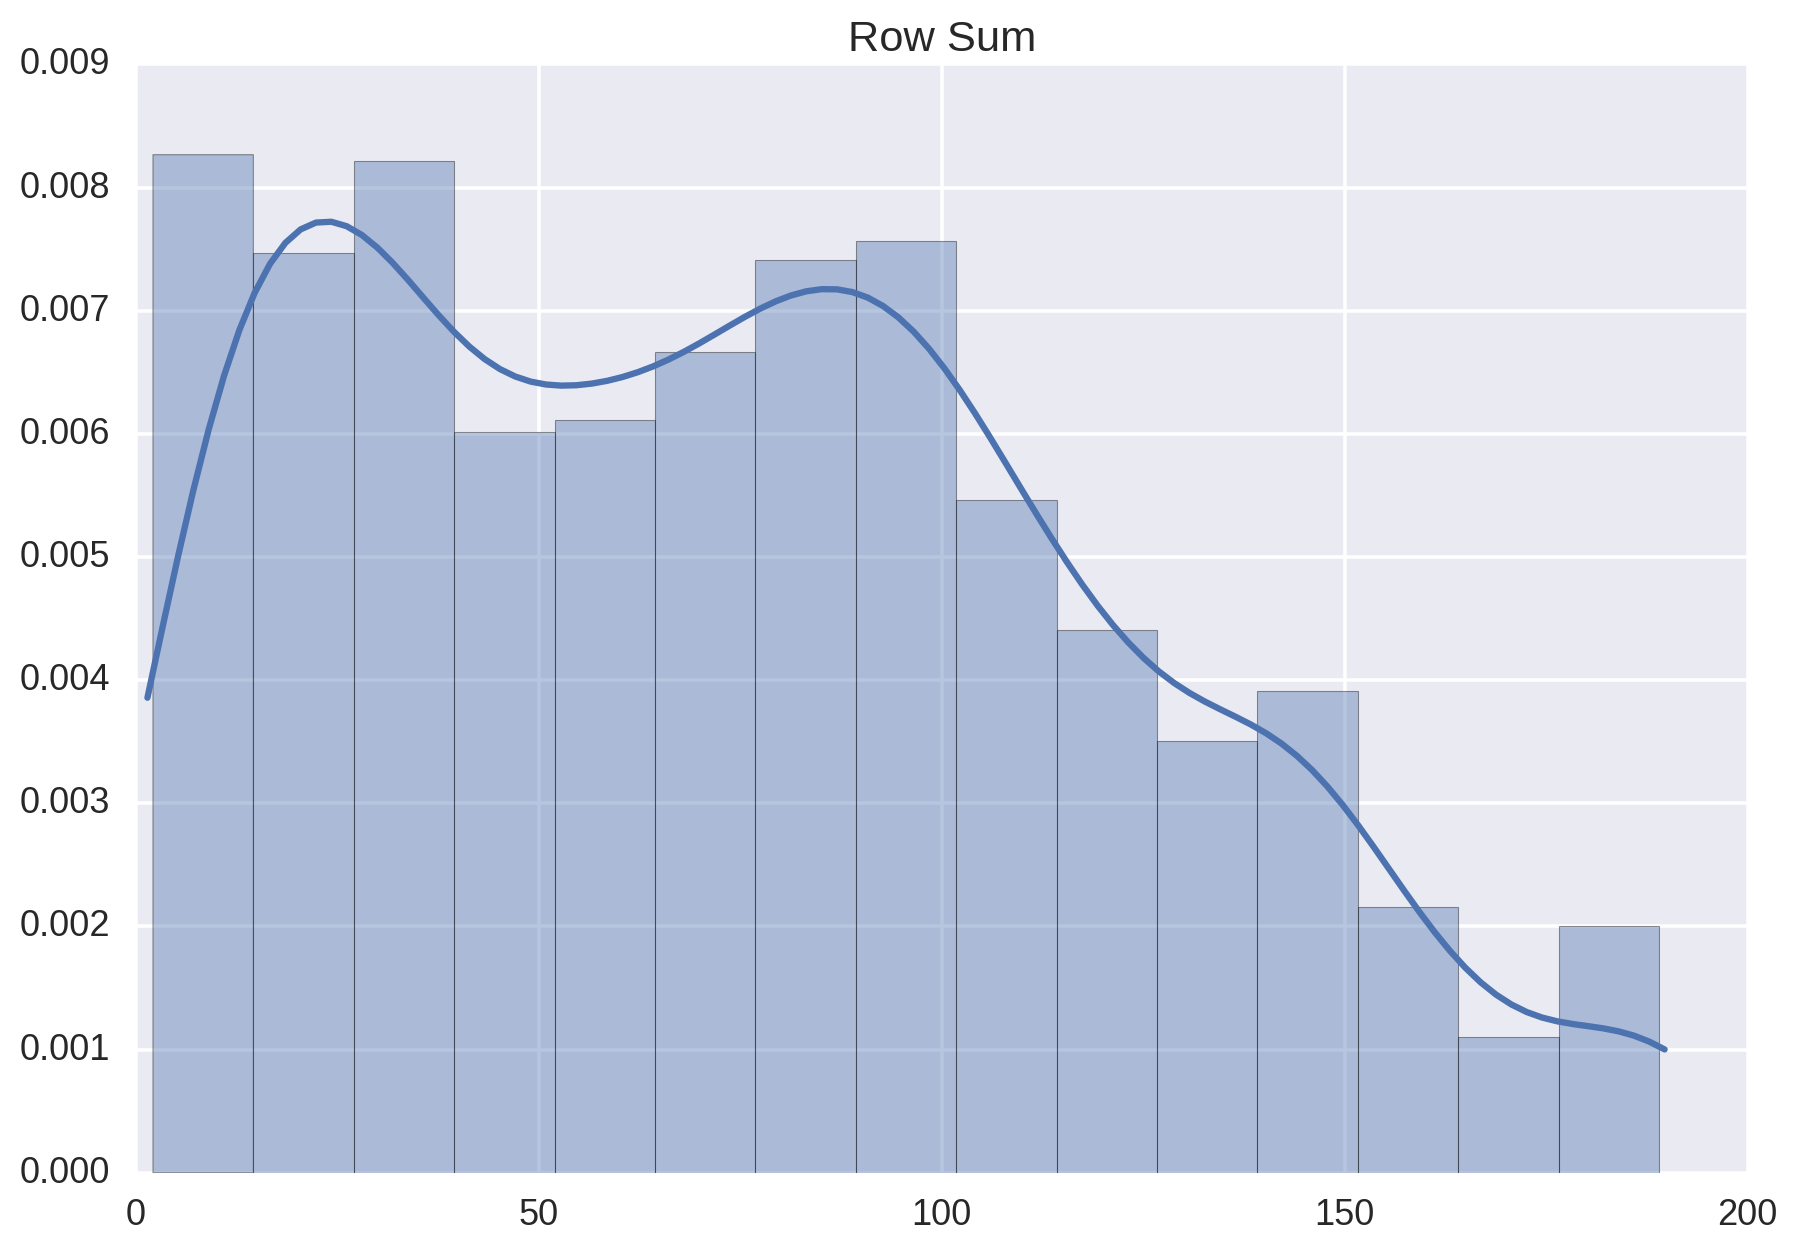

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


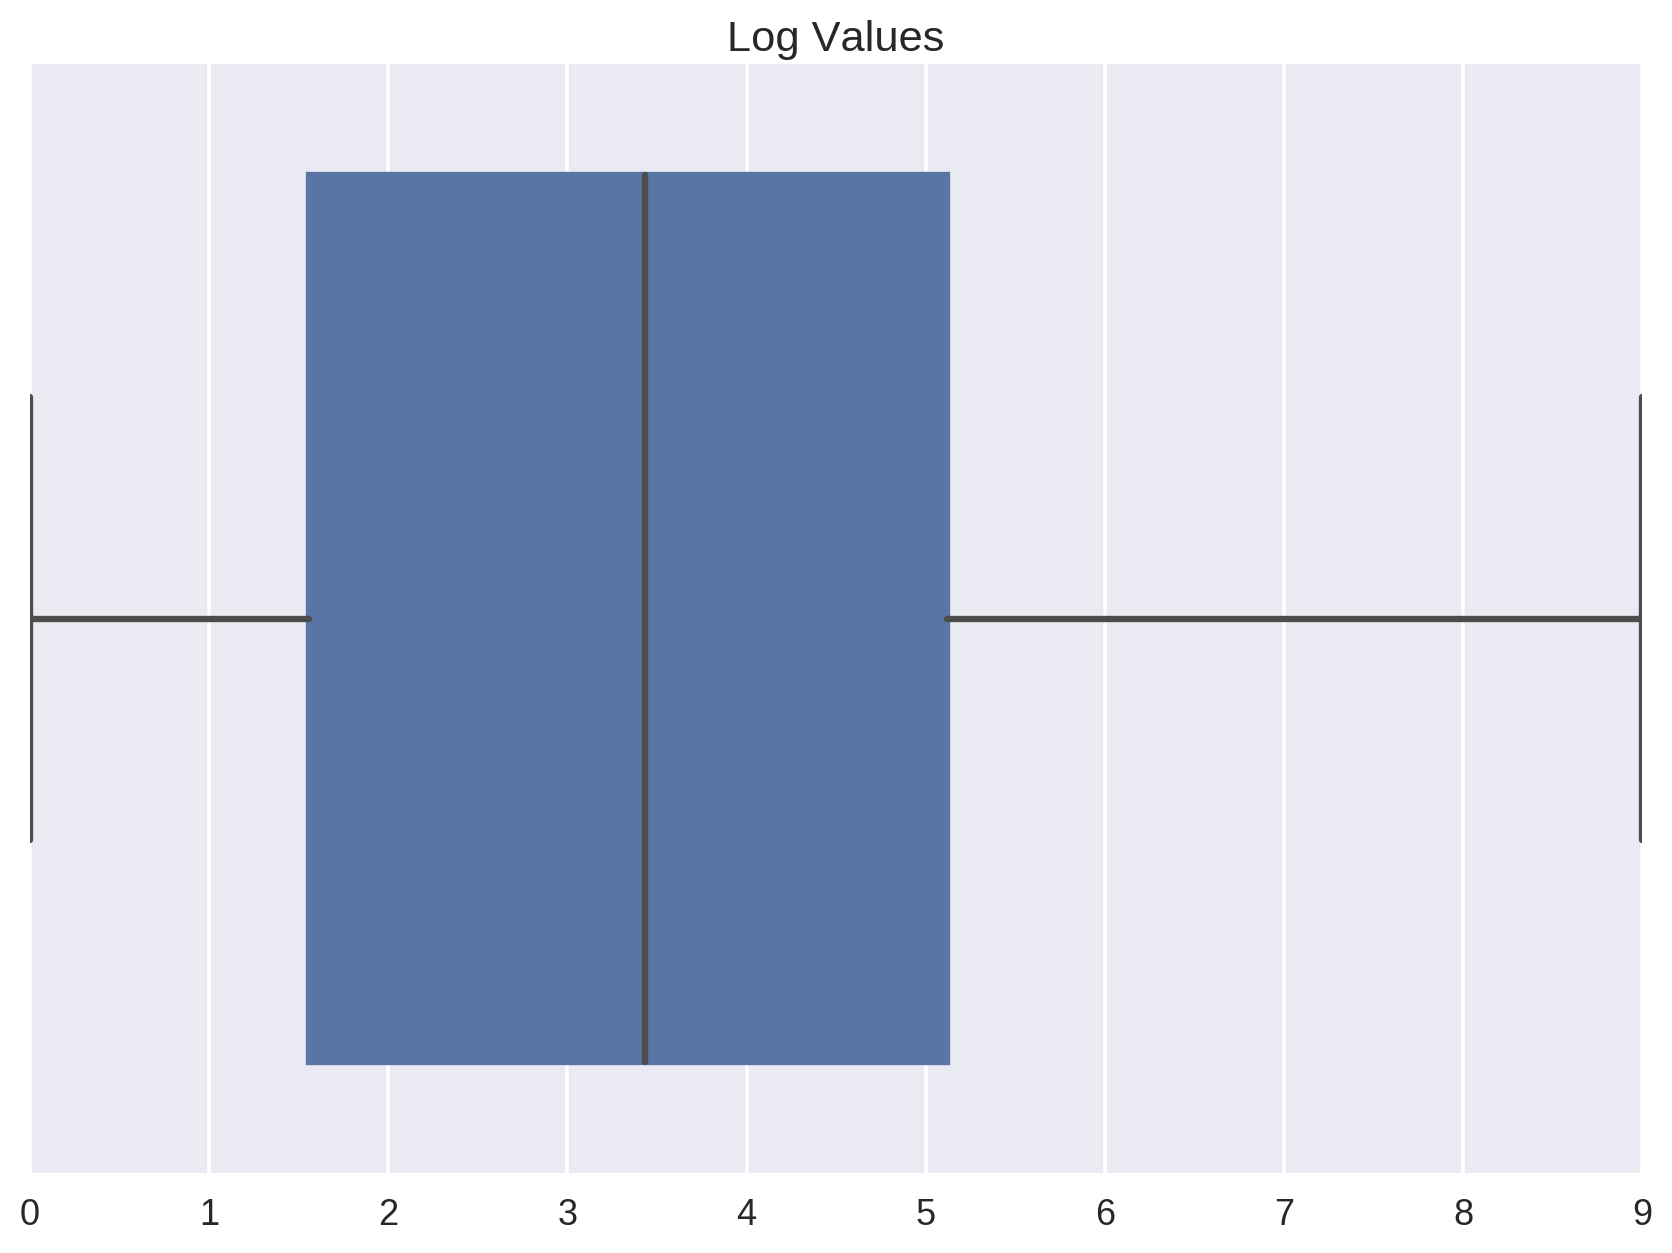

In [43]:
sns.distplot(log_data.sum(axis=1))
plt.title("Row Sum")
plt.show()
sns.boxplot(log_data.values.flatten())
plt.title("Log Values")
plt.show()

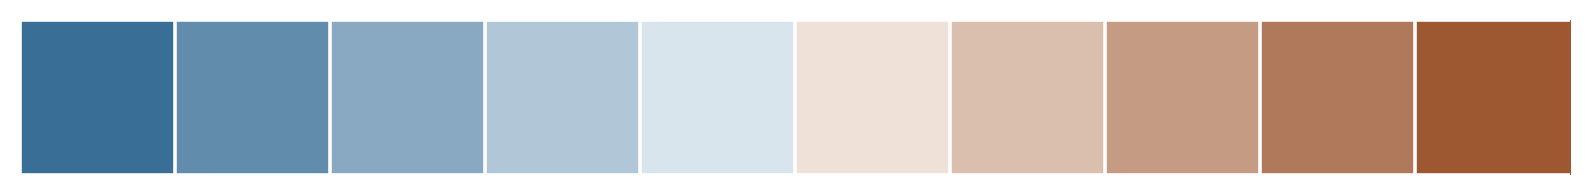

In [44]:
colorDict= {}
sns.palplot(sns.diverging_palette(240,30, sep=1, n=10, l=45))
cp = sns.color_palette("colorblind", 10)
for i in range(10):
    colorDict[i + 1] = cp[i]

In [ ]:
numSampleClusters = 5
numGeneClusters = 6
cmap = sns.diverging_palette(240,30, sep=1, n=10, l=45, as_cmap=True)
cg = sns.clustermap(log_data, cmap=cmap)

sample_linkage = cg.dendrogram_col.linkage
gene_linkage = cg.dendrogram_row.linkage

cg.ax_heatmap.set_yticklabels([]);




In [ ]:
sample_cluster_dict = {}

sample_flatCluster = scipy.cluster.hierarchy.fcluster(sample_linkage, numSampleClusters, criterion="maxclust")

gene_flatCluster = scipy.cluster.hierarchy.fcluster(gene_linkage, numGeneClusters, criterion="maxclust")

sample_reorderedInd = cg.dendrogram_col.reordered_ind

# for i in range(len(sample_reorderedInd)):
#     sample = log_data.columns[i]
#     cluster = sample_flatCluster[i]
#     sample_cluster_dict[sample] = cluster
    

gene_colors = [colorDict[gene_flatCluster[i]] for i in range(len(log_data.index))]
sample_colors = [colorDict[sample_flatCluster[i]] for i in range(len(log_data.columns))]

cg_colored = sns.clustermap(log_data, 
                         row_linkage = gene_linkage,
                         col_linkage = sample_linkage,
                         figsize=(15, 15), linewidths=0.0, 
                         row_colors = gene_colors,
                         col_colors = sample_colors,
                         cmap=cmap
                         )

cg_colored.ax_heatmap.set_yticklabels([]);



In [ ]:
cg_1 = sns.clustermap(log_data[gene_flatCluster ==1])
cg_1.ax_heatmap.set_yticklabels([refseq_gene_mapping[x] for x in log_data[gene_flatCluster ==1].index]);
plt.title("Cluster 1")

In [ ]:
cg_2 = sns.clustermap(log_data[gene_flatCluster ==2])
cg_2.ax_heatmap.set_yticklabels([]);
plt.title("Cluster 2")

In [ ]:
cg_3 = sns.clustermap(log_data[gene_flatCluster ==3])
cg_3.ax_heatmap.set_yticklabels([]);
plt.title("Cluster 3")

In [ ]:
cg_4 = sns.clustermap(log_data[gene_flatCluster ==4])
cg_4.ax_heatmap.set_yticklabels([]);
plt.title("Cluster 4")

In [ ]:
cg_5 = sns.clustermap(log_data[gene_flatCluster ==5])
cg_5.ax_heatmap.set_yticklabels([]);
plt.title("Cluster 5)



In [ ]:
cg_6 = sns.clustermap(log_data[gene_flatCluster ==6])
cg_6.ax_heatmap.set_yticklabels([]);
plt.title("Cluster 6")

## 12/4/15 Lab Meeting

In [ ]:
# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame['originalName'].values]]
columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 18]

# create frame that's easier to use with factor plots
pivoting_frame = filtered_rpkm_frame.transpose()
_refseq = []
_gene = []
_rpkm = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(filtered_summary_frame['simpleTreatment'].values) * pivoting_frame.shape[1]
for refseq in pivoting_frame.columns:
    gene = refseq_gene_mapping[refseq]
    for rpkm in pivoting_frame[refseq].values:
        _rpkm.append(rpkm)
        _refseq.append(refseq)
        _gene.append(gene)
filtered_rpkm_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'rpkm': _rpkm,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
del pivoting_frame
        
filtered_rpkm_plottingFrame_log = filtered_rpkm_plottingFrame.copy()
filtered_rpkm_plottingFrame_log['rpkm'] = np.log2(filtered_rpkm_plottingFrame.rpkm)






In [105]:
idr_frame = rpkm_frame.ix[:,9:]
idr_frame.index = rpkm_frame['refseq'].values
idr_frame.columns = [sampleName_simpleName_dict[x].split('_')[0] for x in idr_frame.columns.values]
for treatment in set(idr_frame.columns.values):
    idr_frame[treatment + '_mean'] = np.mean(idr_frame[treatment], axis=1)
for col in set(idr_frame.columns):
    if not '_mean' in col:
        del idr_frame[col]

idr_frame.columns = [x.split('_')[0] for x in idr_frame.columns.values]

intersecting_refseqs = None
for p in os.listdir(idrDirectory):
    if "idrUnion" in p:
        with open(idrDirectory + '/' +p) as f:
            data = f.readlines()
        refseqs = []
        for line in data[1:]:
            tokens = line.split("\t")
            refseq = tokens[0]
            refseqs.append(refseq)
        if intersecting_refseqs == None:
            intersecting_refseqs = set(refseqs)
        else:
            intersecting_refseqs = intersecting_refseqs.intersection(set(refseqs))
mean_frame = idr_frame 

idr_frame = idr_frame[idr_frame.index.isin(intersecting_refseqs)]

# create frame for plotting
pivoting_frame = idr_frame.transpose()
_refseq = []
_gene = []
_rpkm = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(idr_frame.columns.values) * pivoting_frame.shape[1]
for refseq in pivoting_frame.columns:
    gene = refseq_gene_mapping[refseq]
    for rpkm in pivoting_frame[refseq].values:
        _rpkm.append(rpkm)
        _refseq.append(refseq)
        _gene.append(gene.lower())
idr_plotting_frame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'rpkm': _rpkm,
'treatment': _treatment
})
del pivoting_frame
        
pivoting_frame = mean_frame.transpose()
_refseq = []
_gene = []
_rpkm = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(mean_frame.columns.values) * pivoting_frame.shape[1]
for refseq in pivoting_frame.columns:
    gene = refseq_gene_mapping[refseq]
    for rpkm in pivoting_frame[refseq].values:
        _rpkm.append(rpkm)
        _refseq.append(refseq)
        _gene.append(gene.lower())
mean_plotting_frame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'rpkm': _rpkm,
'treatment': _treatment
})
del pivoting_frame


In [103]:
target_genes = [x.lower() for x in ['DHCR24',
'FASN',
'SREBF1',
'SREBF2',
'SCD1',
'SCD2',
'HMGCR',
'ABCA1',
'ABCG1',
'MYLIP',
'LDLR',
'ACACA',
'Acacb',
'DHCR7',
'CYP51',
'APOC1',
'APOC2',
'APOE',
'LPL',
# 'CETP',
'ABCG5',
'ABCG8',
'APOC2',
'ANGPTL3',
'CYP7A1',
'VLDLR',
'PLTP',
'MERTK',
'PCSK9',
'INSIG1']]

In [ ]:
for g in target_genes:
    sns.factorplot(y='rpkm', 
                 x='treatment',
                 row='gene',
                 size = 8,
                 hue='treatment',
                 kind='bar',
                 data=filtered_rpkm_plottingFrame[filtered_rpkm_plottingFrame['gene'] == g])
    plt.savefig(g+'_bar.png')